In [296]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, LeaveOneOut
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, root_mean_squared_error
from sklearn.ensemble import StackingRegressor
from sklearn.preprocessing import StandardScaler
import scipy.stats as stats
import pylab

In [297]:
# Load the data from the CSV file
sales_data = pd.read_csv('sales_data.csv')
sales_data.head(10)

,OrderQty,UnitPrice,LineTotal,TotalDue,Category,Country,SalesYTD,SalesLastYear,datetime
0,1,3578.2700,3578.2700,3953.9884,Bikes,Canada,6.771829e+06,5.693989e+06,2011-05-31
1,1,3399.9900,3399.9900,3756.9890,Bikes,France,4.772398e+06,2.396540e+06,2011-05-31
2,1,3399.9900,3399.9900,3756.9890,Bikes,United States,7.887187e+06,3.298694e+06,2011-05-31
3,1,699.0982,699.0982,772.5036,Bikes,United States,1.051085e+07,5.366576e+06,2011-05-31
4,1,3399.9900,3399.9900,3756.9890,Bikes,Australia,5.977815e+06,2.278549e+06,2011-05-31
5,1,3578.2700,3578.2700,3953.9884,Bikes,United States,1.051085e+07,5.366576e+06,2011-06-01
6,1,3578.2700,3578.2700,3953.9884,Bikes,Australia,5.977815e+06,2.278549e+06,2011-06-01
7,1,3374.9900,3374.9900,3729.3640,Bikes,Australia,5.977815e+06,2.278549e+06,2011-06-01
8,1,3399.9900,3399.9900,3756.9890,Bikes,Australia,5.977815e+06,2.278549e+06,2011-06-01
9,1,3578.2700,3578.2700,3953.9884,Bikes,United States,1.051085e+07,5.366576e+06,2011-06-02


In [298]:
# Convert 'datetime' column to datetime type
sales_data['datetime'] = pd.to_datetime(sales_data['datetime'])

# Set 'datetime' as the index
sales_data.set_index('datetime', inplace=True)
sales_data.head()

,OrderQty,UnitPrice,LineTotal,TotalDue,Category,Country,SalesYTD,SalesLastYear
datetime,,,,,,,,
2011-05-31,1,3578.2700,3578.2700,3953.9884,Bikes,Canada,6.771829e+06,5.693989e+06
2011-05-31,1,3399.9900,3399.9900,3756.9890,Bikes,France,4.772398e+06,2.396540e+06
2011-05-31,1,3399.9900,3399.9900,3756.9890,Bikes,United States,7.887187e+06,3.298694e+06
2011-05-31,1,699.0982,699.0982,772.5036,Bikes,United States,1.051085e+07,5.366576e+06
2011-05-31,1,3399.9900,3399.9900,3756.9890,Bikes,Australia,5.977815e+06,2.278549e+06


In [299]:
countries = sales_data['Country'].unique()
countries = list(countries)

In [300]:
sales_data_country = {country: sales_data[sales_data['Country'] == country] for country in countries}


sales_data_country[countries[0]]
    

,OrderQty,UnitPrice,LineTotal,TotalDue,Category,Country,SalesYTD,SalesLastYear
datetime,,,,,,,,
2011-05-31,1,3578.27,3578.27,3953.9884,Bikes,Canada,6.771829e+06,5693988.86
2011-06-18,1,3578.27,3578.27,3953.9884,Bikes,Canada,6.771829e+06,5693988.86
2011-06-23,1,3578.27,3578.27,3953.9884,Bikes,Canada,6.771829e+06,5693988.86
2011-06-24,1,3578.27,3578.27,3953.9884,Bikes,Canada,6.771829e+06,5693988.86
2011-06-29,1,3578.27,3578.27,3953.9884,Bikes,Canada,6.771829e+06,5693988.86
...,...,...,...,...,...,...,...,...
2014-06-30,1,21.98,21.98,34.2219,Accessories,Canada,6.771829e+06,5693988.86
2014-06-30,1,8.99,8.99,34.2219,Clothing,Canada,6.771829e+06,5693988.86
2014-06-30,1,21.98,21.98,209.9169,Accessories,Canada,6.771829e+06,5693988.86


In [301]:
def train_test_split_country(sales_data_country):
    combine_train_test = {
        country: data['TotalDue'].resample('ME').sum() for country, data in sales_data_country.items()
    }
    
    
    train_monthly_sales_by_country = {
        country: data['TotalDue'].resample('ME').sum()[:-6] for country, data in sales_data_country.items()
    }
    
    test_monthly_sales_by_country = {
        country: data['TotalDue'].resample('ME').sum()[-6:] for country, data in sales_data_country.items()
    }
    
    return (combine_train_test, train_monthly_sales_by_country, test_monthly_sales_by_country)

In [302]:
# Resample 'TotalDue' for each country in the dictionary
combined_data, train_data, test_data = train_test_split_country(sales_data_country)

# Example: Access the resampled data for the first country
first_country = countries[0]
print(f"Monthly sales for country '{first_country}':")
print(train_data[first_country]) 

Monthly sales for country 'Canada':
datetime
2011-05-31    2.395443e+06
2011-06-30    2.031782e+04
2011-07-31    4.512899e+06
2011-08-31    7.471918e+06
2011-09-30    1.318235e+04
2011-10-31    1.216474e+07
2011-11-30    4.008776e+04
2011-12-31    2.951436e+06
2012-01-31    9.267895e+06
2012-02-29    5.144809e+06
2012-03-31    7.162063e+06
2012-04-30    4.784907e+06
2012-05-31    3.182959e+07
2012-06-30    2.749437e+07
2012-07-31    2.656807e+07
2012-08-31    1.823936e+07
2012-09-30    1.852332e+07
2012-10-31    1.934808e+07
2012-11-30    9.507634e+06
2012-12-31    8.394028e+06
2013-01-31    1.055846e+07
2013-02-28    1.947355e+07
2013-03-31    1.839098e+07
2013-04-30    1.810397e+07
2013-05-31    2.315323e+07
2013-06-30    2.212995e+07
2013-07-31    3.095634e+07
2013-08-31    1.611709e+07
2013-09-30    1.378287e+07
2013-10-31    2.673192e+07
2013-11-30    7.339794e+06
2013-12-31    7.924098e+06
Freq: ME, Name: TotalDue, dtype: float64


In [303]:
print(test_data[first_country]) 

datetime
2014-01-31    1.346066e+07
2014-02-28    2.559653e+05
2014-03-31    2.818234e+07
2014-04-30    4.437361e+05
2014-05-31    2.253944e+07
2014-06-30    3.117614e+04
Freq: ME, Name: TotalDue, dtype: float64


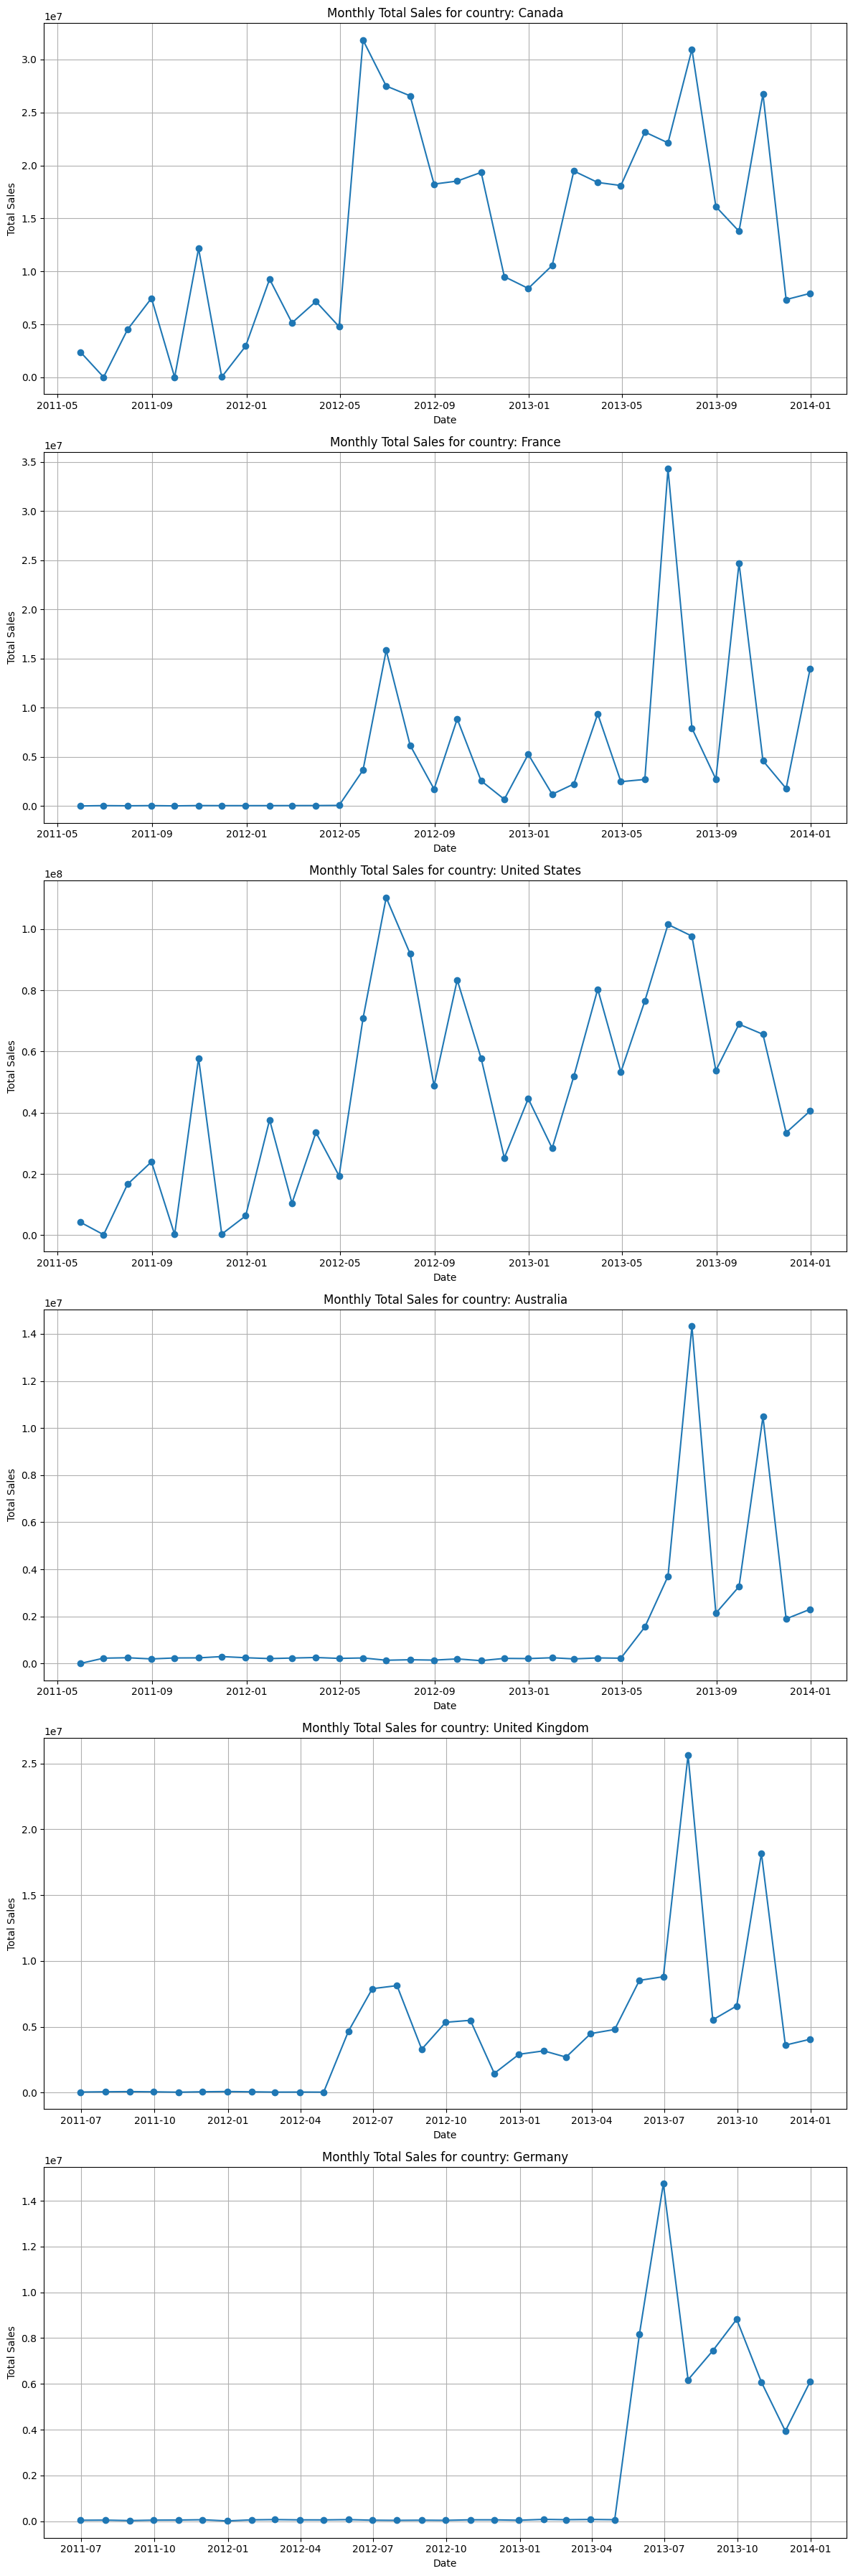

In [304]:
n_countries = len(countries)  # Total number of countries

plt.figure(figsize=(12, 6 * n_countries))  # Adjust figure size dynamically based on the number of countries

for i, (country, monthly_sales) in enumerate(train_data.items(), 1):
    plt.subplot(n_countries, 1, i)
    plt.plot(monthly_sales, marker='o', linestyle='-')
    plt.title(f"Monthly Total Sales for country: {country}")
    plt.xlabel("Date")
    plt.ylabel("Total Sales")
    plt.grid(True)

# Adjust layout
plt.tight_layout()
plt.show()


In [305]:
def adf_test(series):
    """
    If p-value > 0.05: The time series is non-stationary.
    If p-value ≤ 0.05: The time series is stationary.
    """
    result = adfuller(series)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    for key, value in result[4].items():
        print('Critical Value (%s): %.3f' % (key, value))


# Perform ADF test
for (country, data) in train_data.items():
    print(f'{country}')
    adf_test(data)

Canada
ADF Statistic: -2.232210322016798
p-value: 0.19476330923267954
Critical Value (1%): -3.711
Critical Value (5%): -2.981
Critical Value (10%): -2.630
France
ADF Statistic: -1.799858009298236
p-value: 0.3805321903277764
Critical Value (1%): -3.689
Critical Value (5%): -2.972
Critical Value (10%): -2.625
United States
ADF Statistic: -3.0274174450675675
p-value: 0.0324120809442737
Critical Value (1%): -3.661
Critical Value (5%): -2.961
Critical Value (10%): -2.619
Australia
ADF Statistic: -0.9097581226221825
p-value: 0.7847419443922327
Critical Value (1%): -3.679
Critical Value (5%): -2.968
Critical Value (10%): -2.623
United Kingdom
ADF Statistic: -3.5649630081068024
p-value: 0.006467290018114363
Critical Value (1%): -3.670
Critical Value (5%): -2.964
Critical Value (10%): -2.621
Germany
ADF Statistic: 4.23638260261955
p-value: 1.0
Critical Value (1%): -3.738
Critical Value (5%): -2.992
Critical Value (10%): -2.636


In [306]:
#return p value
def calculate_p_value(data):
    """
    If p-value > 0.05: The time series is non-stationary.
    If p-value ≤ 0.05: The time series is stationary.
    """
    result = adfuller(data)
    return result[1]



#Make the time series stationary
def make_stationary(train_data, test_data):
    """
    Make train_data stationary and apply the same differencing logic to test_data,
    ensuring consistent transformation without combining datasets.
    """
    differencing_info = {}  # Store number of differences for each country
    stationary_train_data = {}
    stationary_test_data = {}

    for country, train_series in train_data.items():
        print(f"\nProcessing country: {country}")
        
        # Initialize differencing count and check train_data for stationarity
        differences = 0
        p_value = calculate_p_value(train_series)
        current_train_series = train_series

        # Apply differencing to train_data until stationary
        while p_value > 0.05:
            current_train_series = current_train_series.diff().dropna()
            differences += 1
            p_value = calculate_p_value(current_train_series)
        
        # Store stationary train data
        stationary_train_data[country] = current_train_series
        differencing_info[country] = differences

        # Apply the same differencing logic to test_data
        current_test_series = test_data[country]
        for _ in range(differences):
            # Use the last value of train_series for differencing
            current_test_series = current_test_series.diff().dropna()
        
        # Store stationary test data
        stationary_test_data[country] = current_test_series

        print(f"Country: {country} - Stationary after {differences} differences.")

    return stationary_train_data, stationary_test_data

# Apply the function to train_data and test_data
train_data, test_data = make_stationary(train_data, test_data)


Processing country: Canada
Country: Canada - Stationary after 1 differences.

Processing country: France
Country: France - Stationary after 1 differences.

Processing country: United States
Country: United States - Stationary after 0 differences.

Processing country: Australia
Country: Australia - Stationary after 1 differences.

Processing country: United Kingdom
Country: United Kingdom - Stationary after 0 differences.

Processing country: Germany
Country: Germany - Stationary after 3 differences.


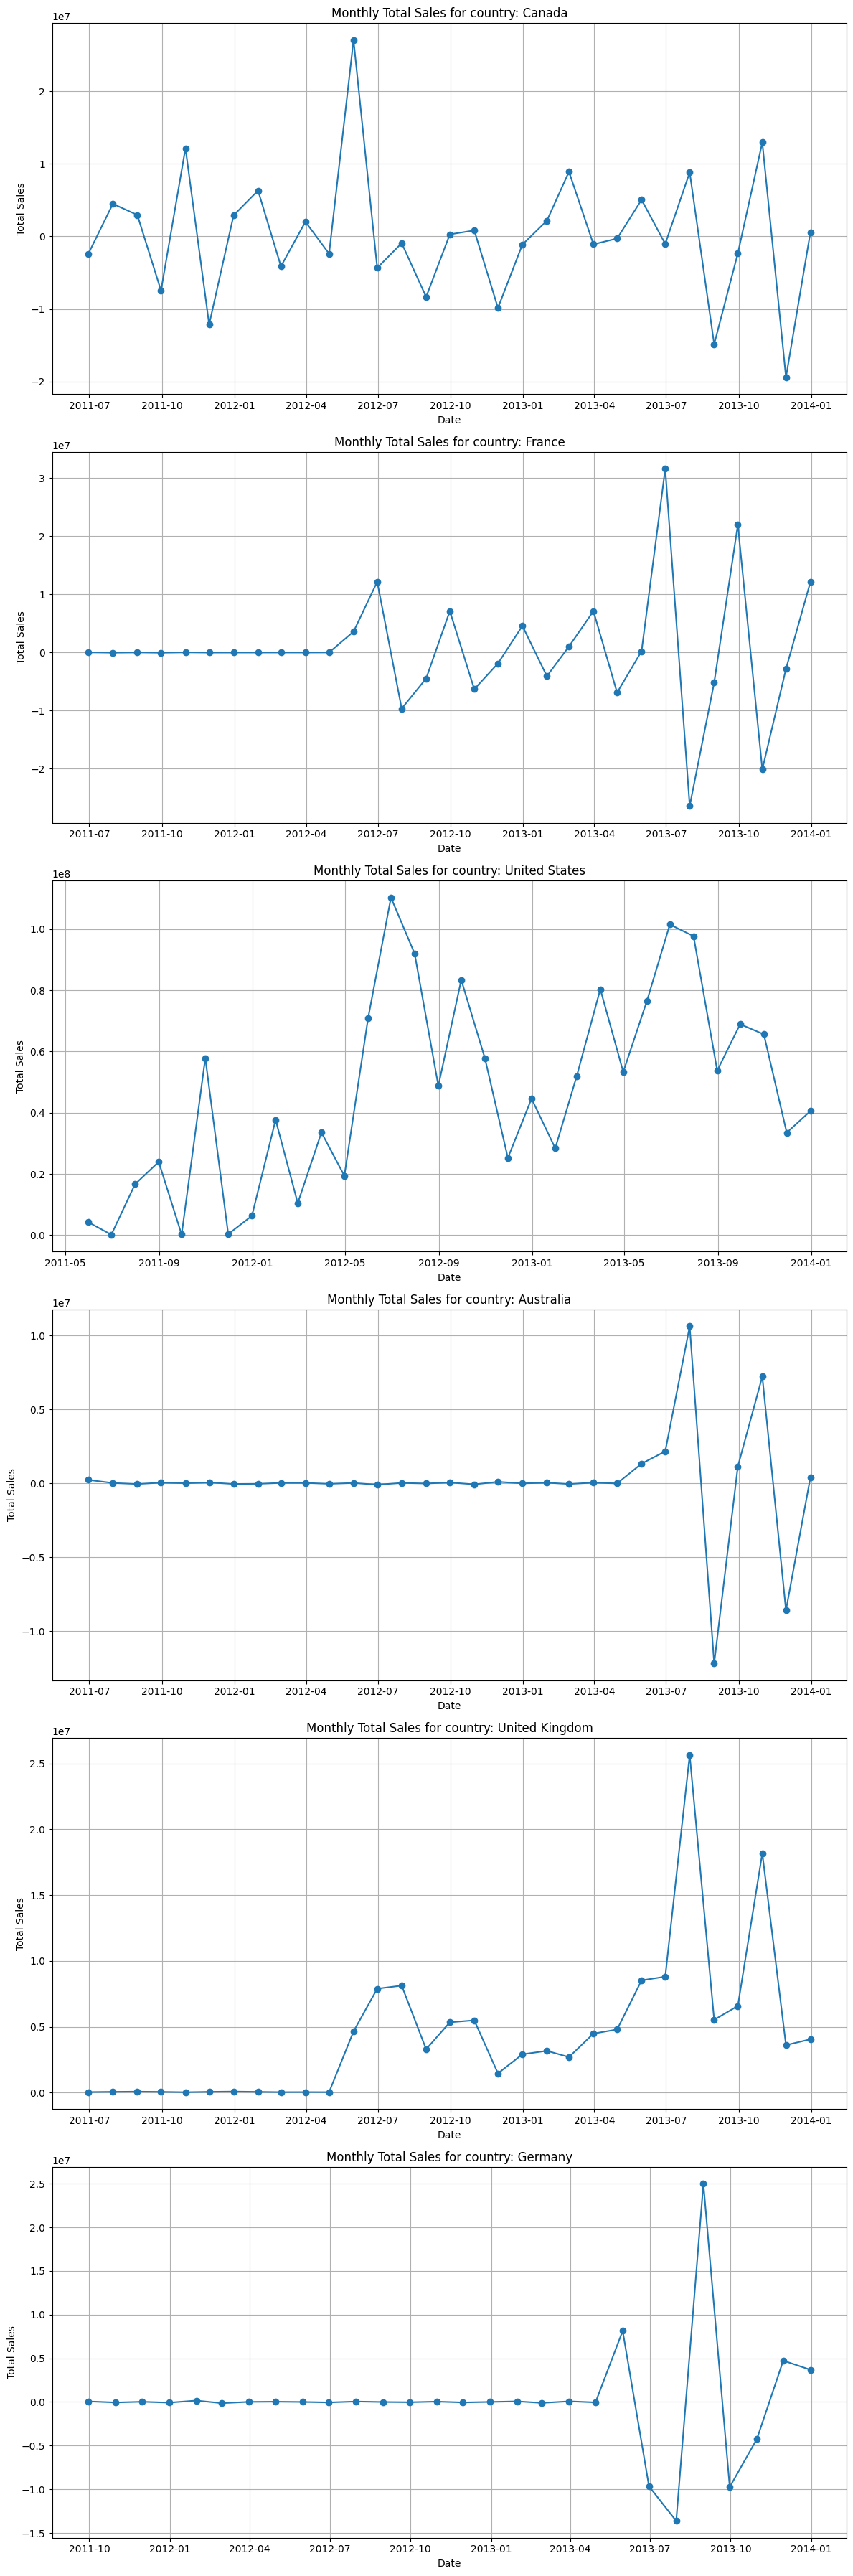

In [307]:
n_countries = len(countries)  # Total number of countries

plt.figure(figsize=(12, 6 * n_countries))  # Adjust figure size dynamically based on the number of countries

for i, (country, monthly_sales) in enumerate(train_data.items(), 1):
    plt.subplot(n_countries, 1, i)
    plt.plot(monthly_sales, marker='o', linestyle='-')
    plt.title(f"Monthly Total Sales for country: {country}")
    plt.xlabel("Date")
    plt.ylabel("Total Sales")
    plt.grid(True)

# Adjust layout
plt.tight_layout()
plt.show()

## ARIMA

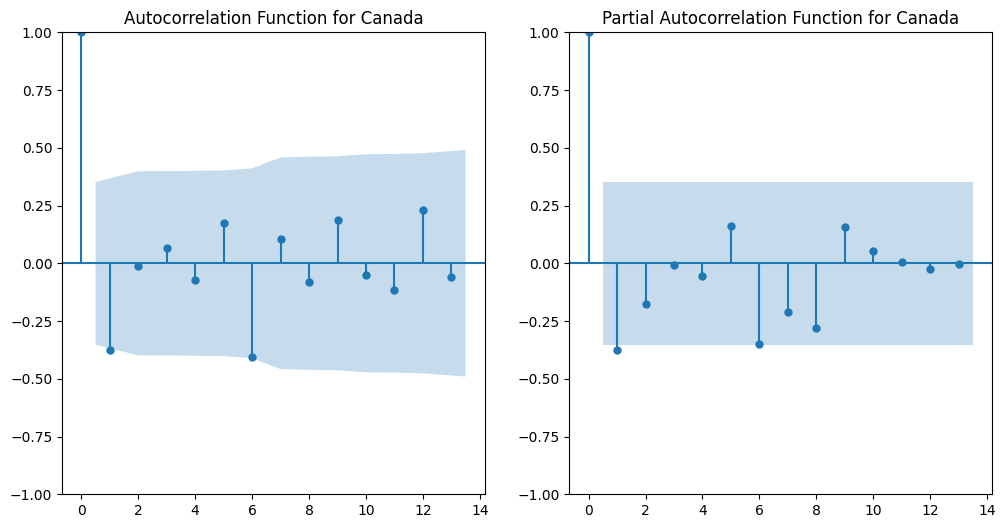

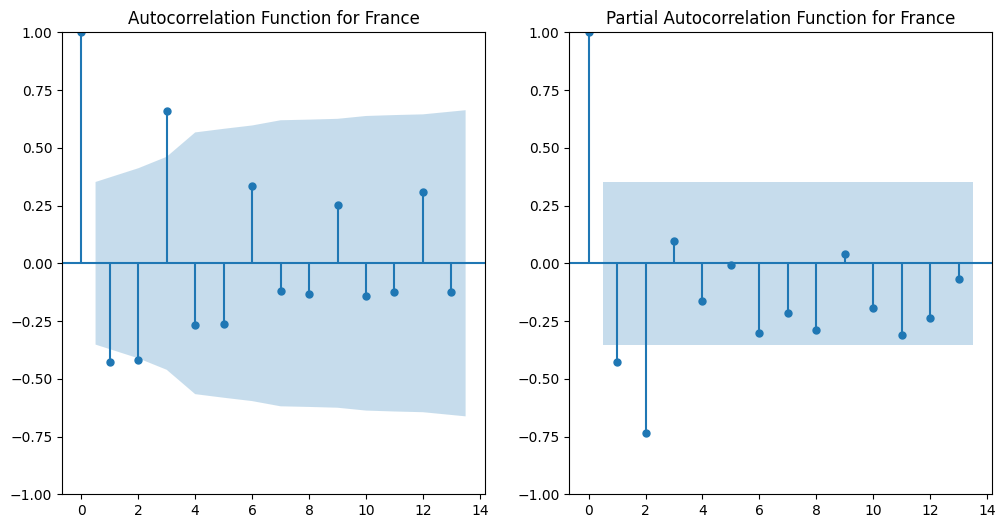

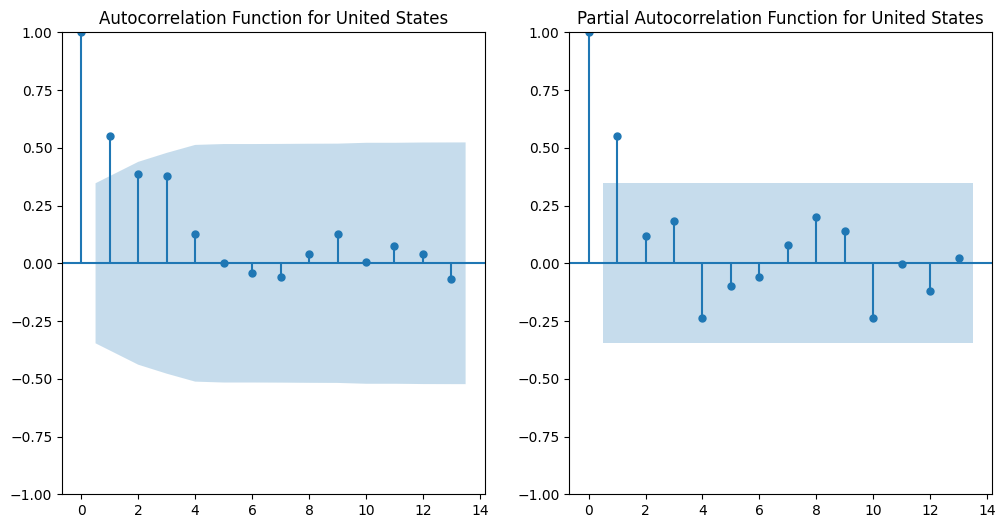

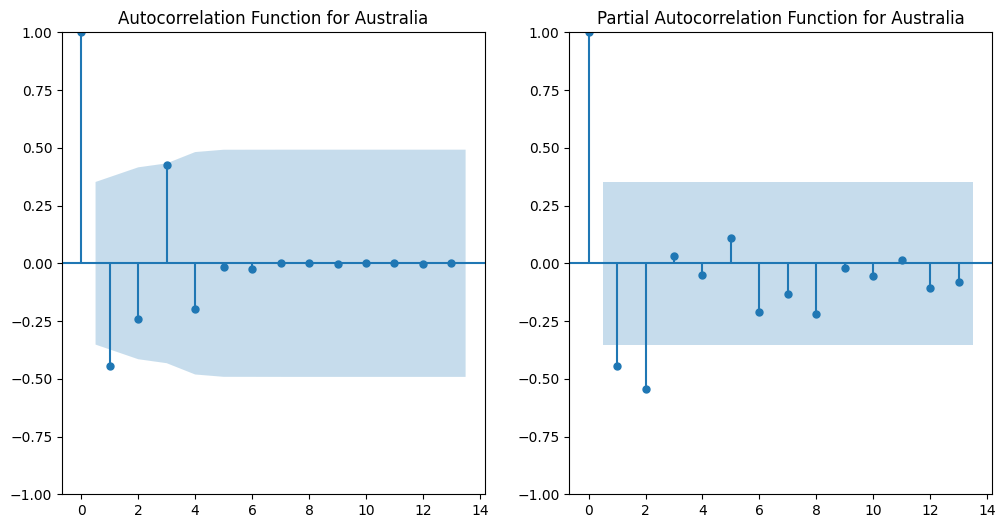

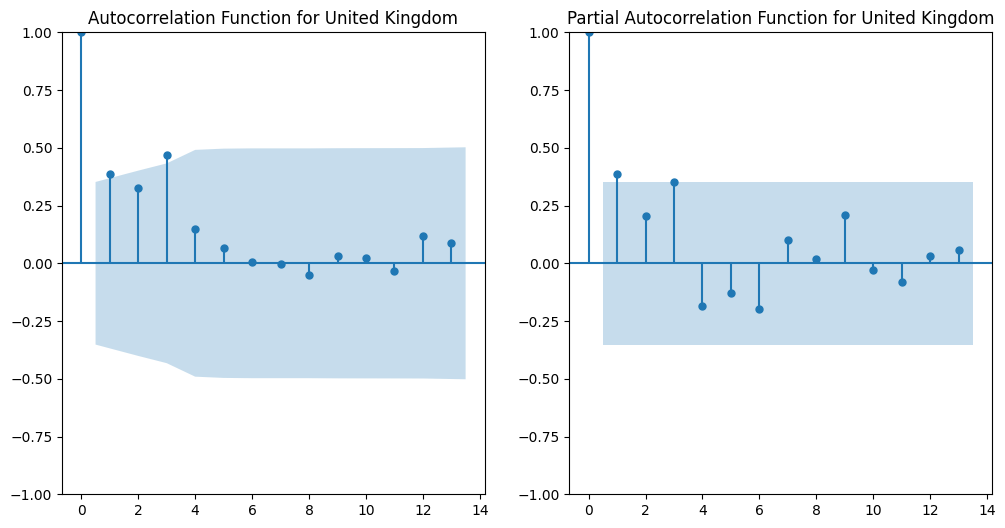

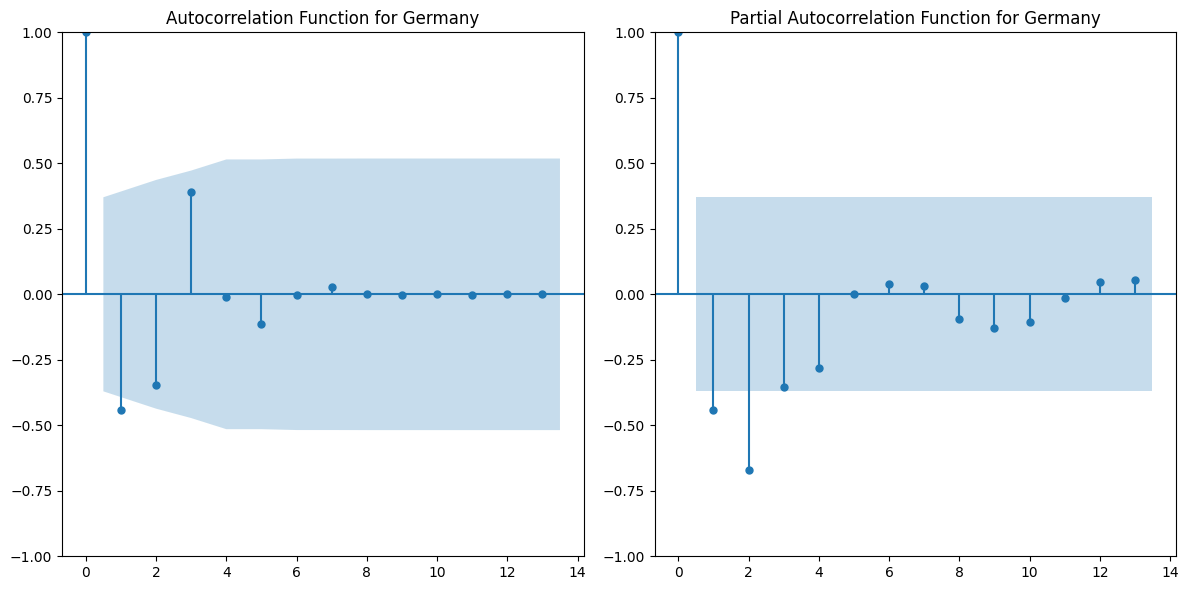

In [308]:
# Define maximum lags (adjust as necessary)
max_lags = 13

# Loop through each country and plot ACF and PACF
for country, monthly_sales in train_data.items():
    plt.figure(figsize=(12, 6))
    
    # Plot ACF
    plt.subplot(121)
    plot_acf(monthly_sales, ax=plt.gca(), lags=max_lags)
    plt.title(f'Autocorrelation Function for {country}')
    
    # Plot PACF
    plt.subplot(122)
    plot_pacf(monthly_sales, ax=plt.gca(), lags=max_lags)
    plt.title(f'Partial Autocorrelation Function for {country}')
    
plt.tight_layout()
plt.show()

In [309]:
from pmdarima import auto_arima

for country, series in train_data.items():
    print(f"Finding best ARIMA order for {country}...")
    model = auto_arima(series, seasonal=False, trace=True, stepwise=True)
    print(f"Best ARIMA order for {country}: {model.order}")

Finding best ARIMA order for Canada...
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=1081.257, Time=0.19 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1080.562, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=1077.983, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1077.170, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1079.051, Time=0.06 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=1079.343, Time=0.06 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=1079.489, Time=0.11 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1079.044, Time=0.01 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0]          
Total fit time: 0.467 seconds
Best ARIMA order for Canada: (0, 0, 1)
Finding best ARIMA order for France...
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=1067.217, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1090.946, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=1086.636, Time=0.0

In [310]:
countries

['Canada', 'France', 'United States', 'Australia', 'United Kingdom', 'Germany']

In [311]:
model_countries = {}

model_countries[countries[0]] = ARIMA(train_data[countries[0]], order=(0, 0, 1))
model_countries[countries[1]] = ARIMA(train_data[countries[1]], order=(2, 0, 0))
model_countries[countries[2]] = ARIMA(train_data[countries[2]], order=(0, 1, 1))
model_countries[countries[3]] = ARIMA(train_data[countries[3]], order=(2, 0, 0))
model_countries[countries[4]] = ARIMA(train_data[countries[4]], order=(2, 1, 0))
model_countries[countries[5]] = ARIMA(train_data[countries[5]], order=(2, 0, 1))

In [312]:
model_fit_countries = {}

for (country, model) in model_countries.items():
    print(country)
    model_fit_countries[country] = model_countries[country].fit()

Canada
France
United States
Australia
United Kingdom
Germany


In [313]:
model_fit_countries.items()

dict_items([('Canada', <statsmodels.tsa.arima.model.ARIMAResultsWrapper object at 0x0000021D64517EC0>), ('France', <statsmodels.tsa.arima.model.ARIMAResultsWrapper object at 0x0000021D62396450>), ('United States', <statsmodels.tsa.arima.model.ARIMAResultsWrapper object at 0x0000021D4AC943E0>), ('Australia', <statsmodels.tsa.arima.model.ARIMAResultsWrapper object at 0x0000021D46A89BB0>), ('United Kingdom', <statsmodels.tsa.arima.model.ARIMAResultsWrapper object at 0x0000021D46A88440>), ('Germany', <statsmodels.tsa.arima.model.ARIMAResultsWrapper object at 0x0000021D46A8B710>)])

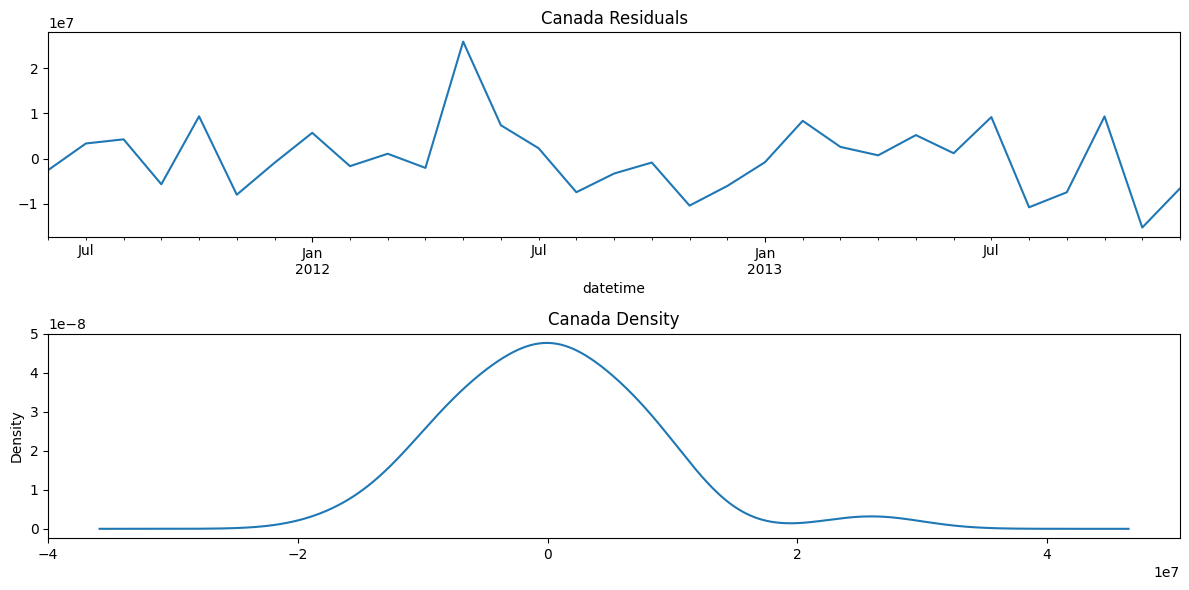

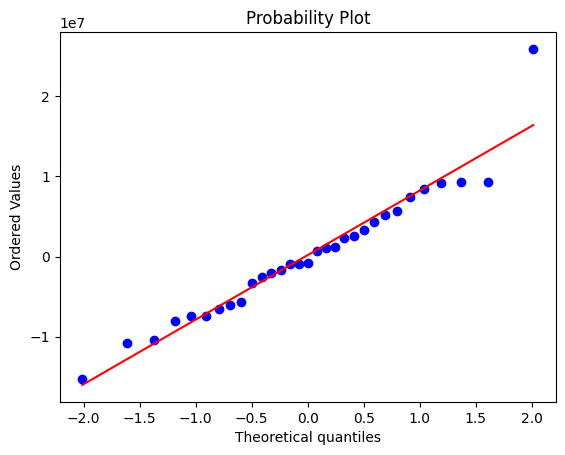

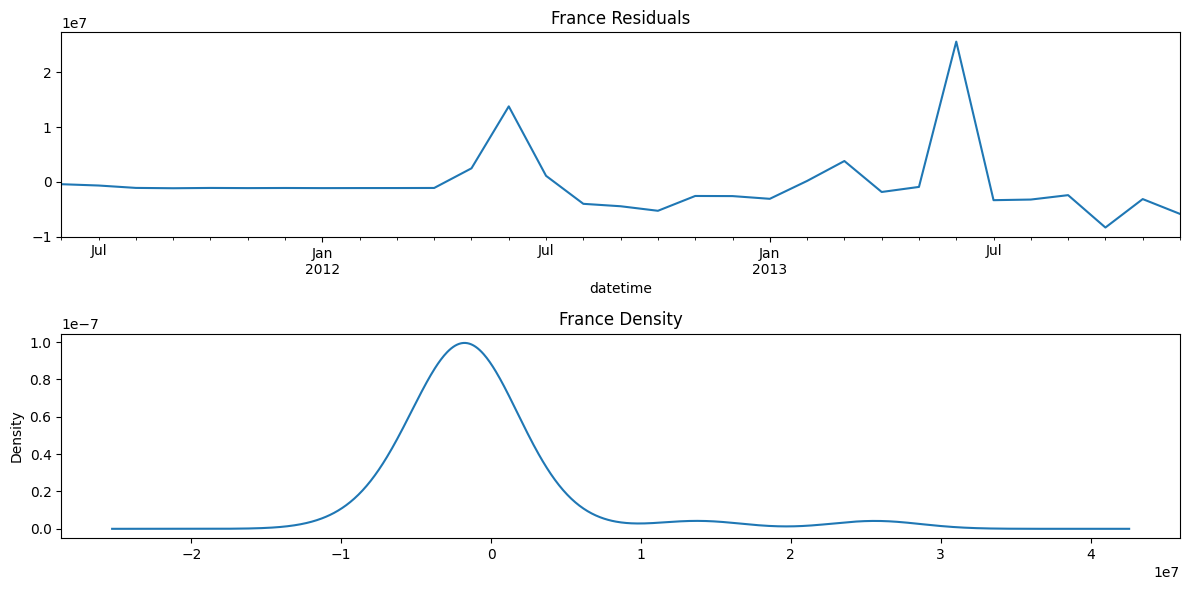

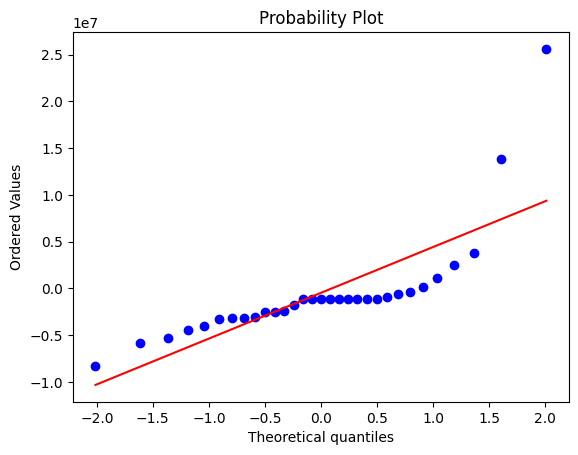

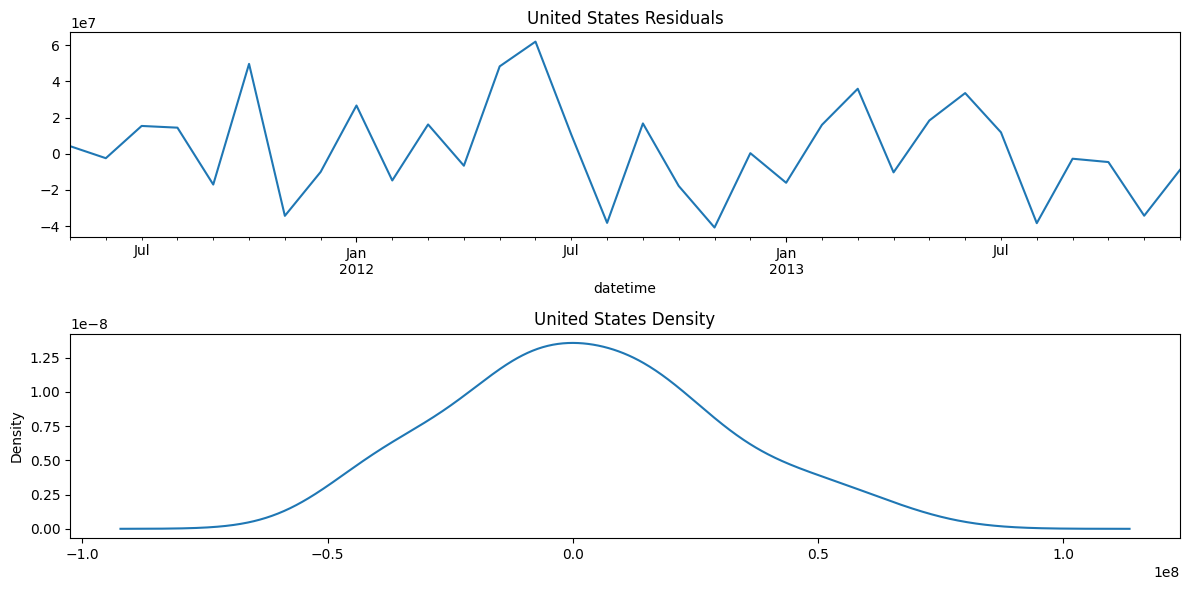

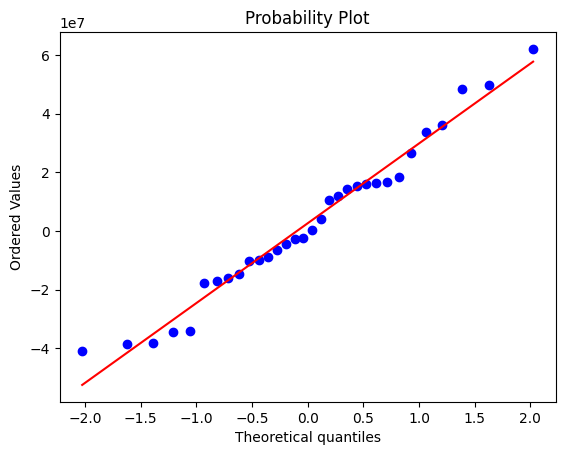

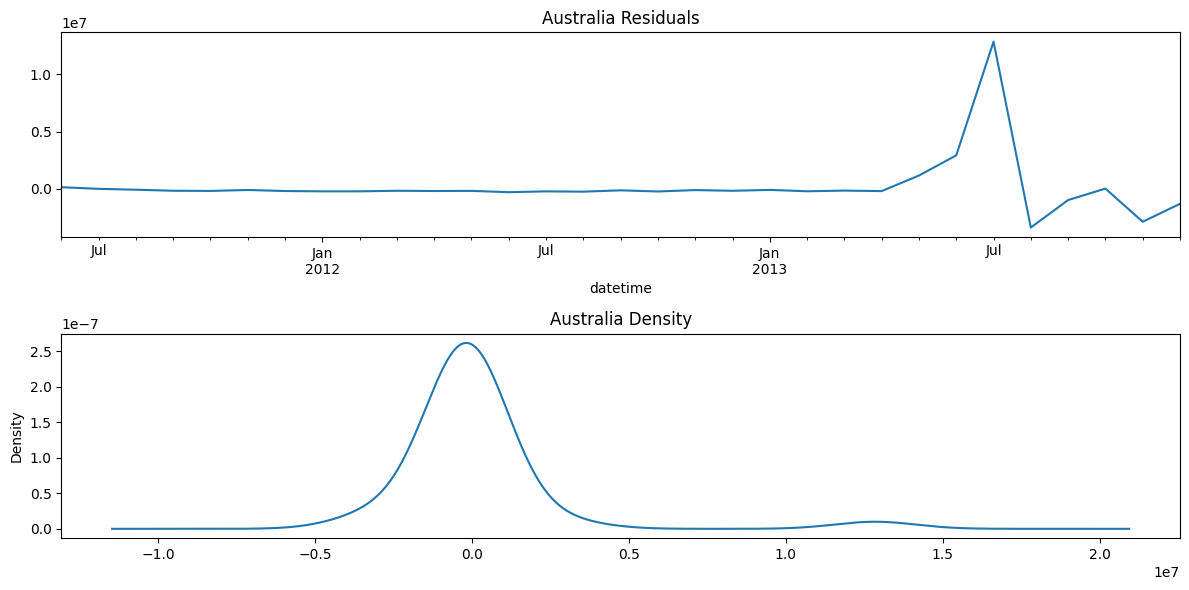

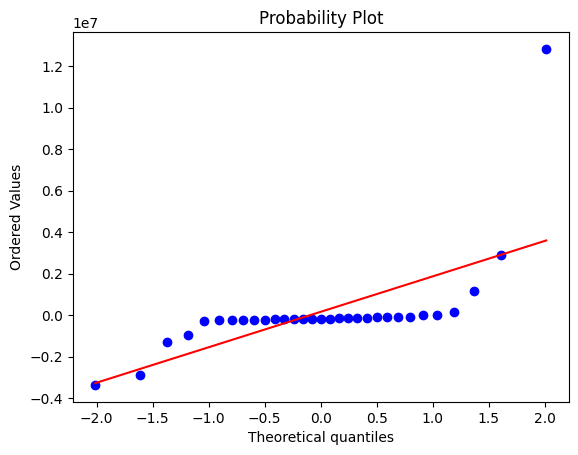

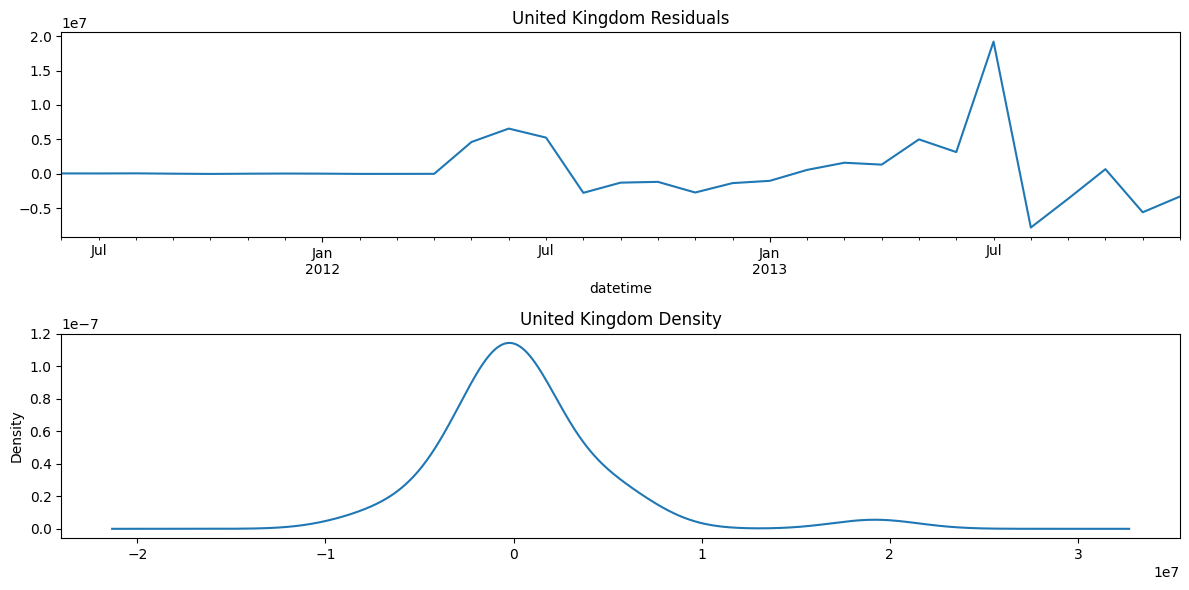

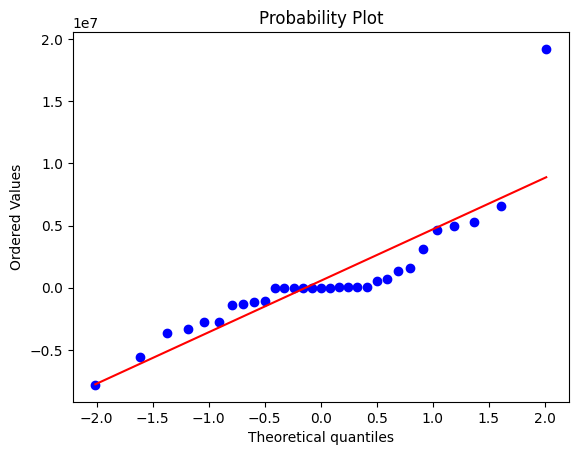

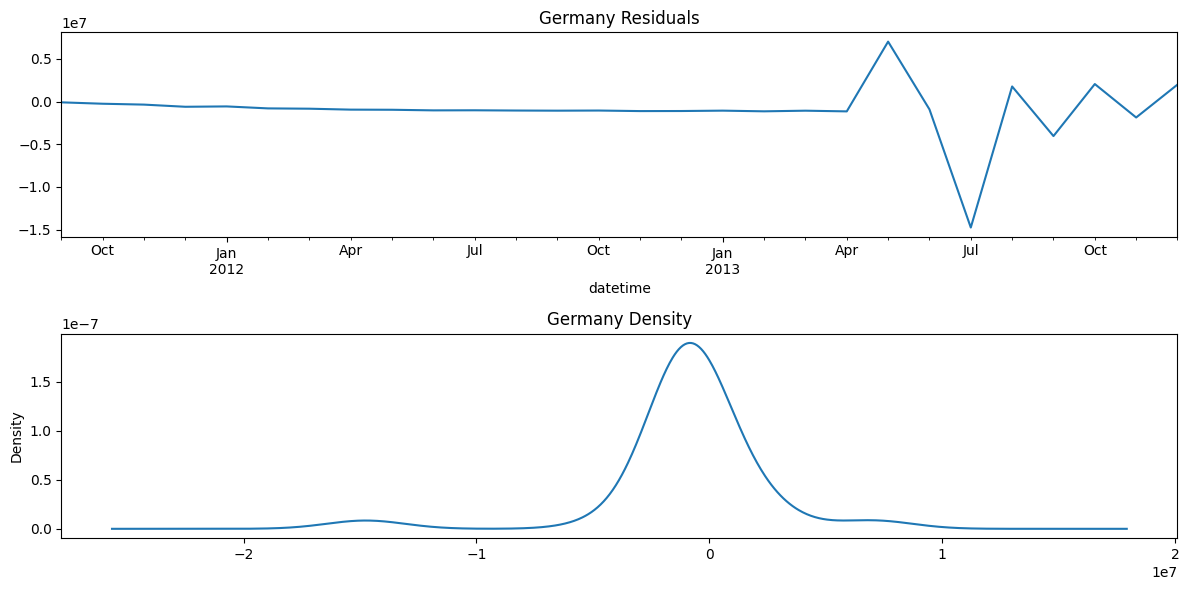

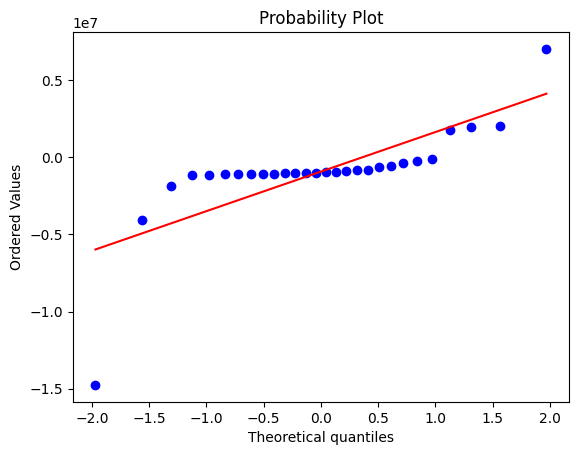

In [314]:
for (country, model) in model_fit_countries.items():
    # Plot residuals
    residuals = model.resid

    plt.figure(figsize=(12, 6))
    plt.subplot(211)
    residuals.plot(title=country + " Residuals", ax=plt.gca())

    plt.subplot(212)
    residuals.plot(kind='kde', title=country + ' Density', ax=plt.gca())

    plt.tight_layout()
    plt.show()

    stats.probplot(residuals, dist="norm", plot=pylab)
    pylab.show()


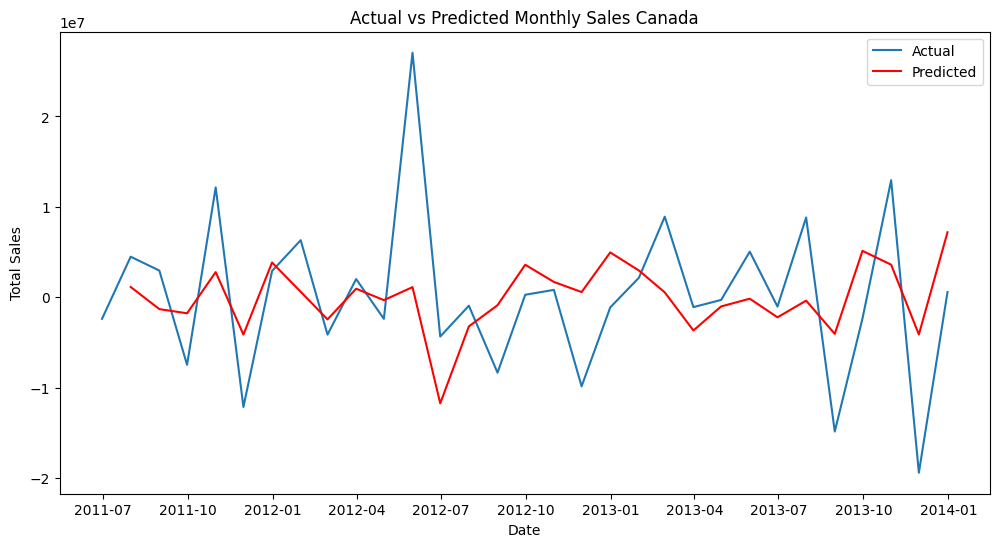

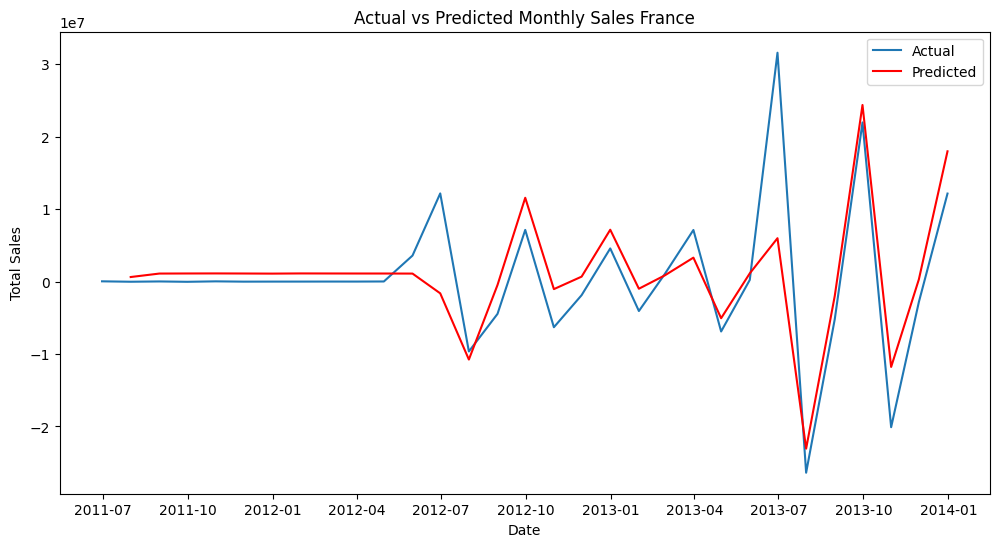

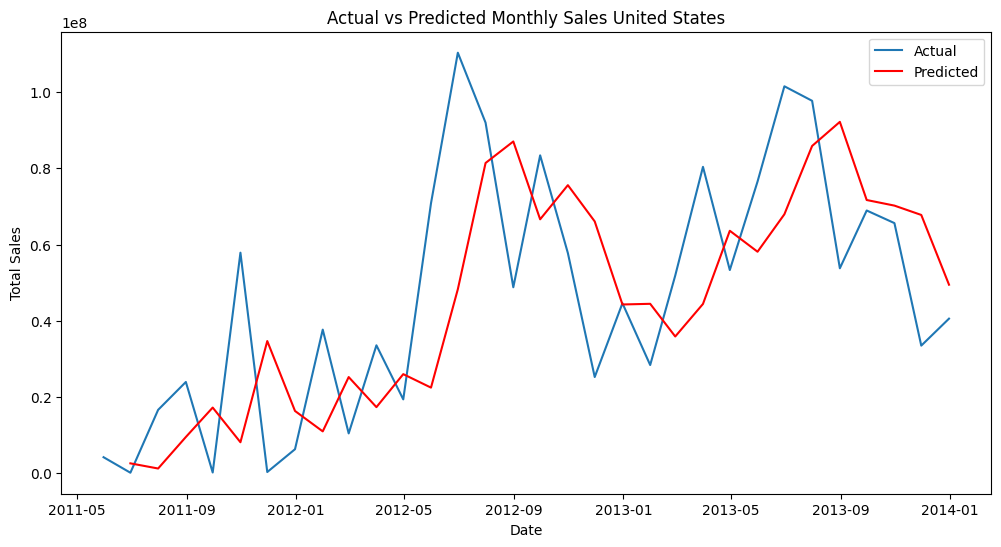

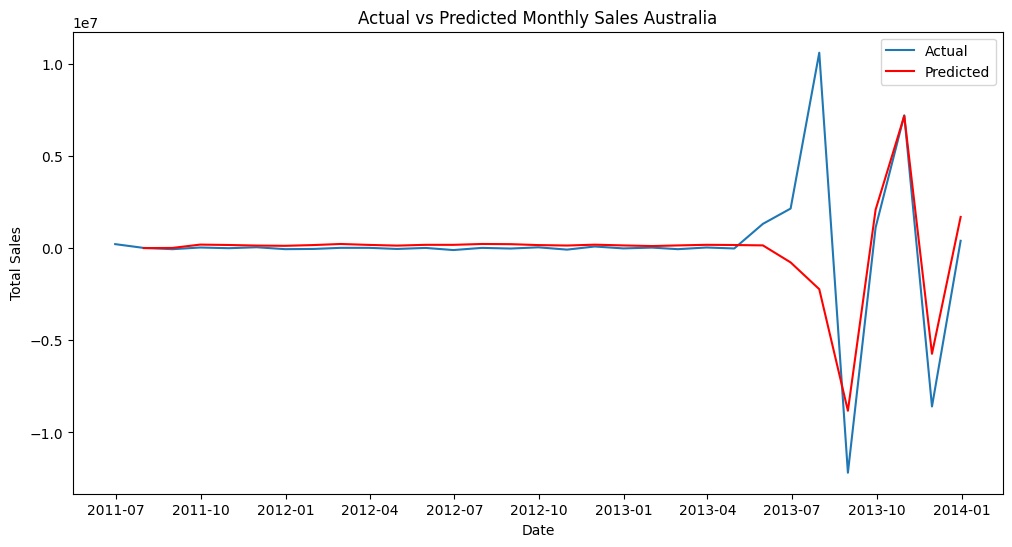

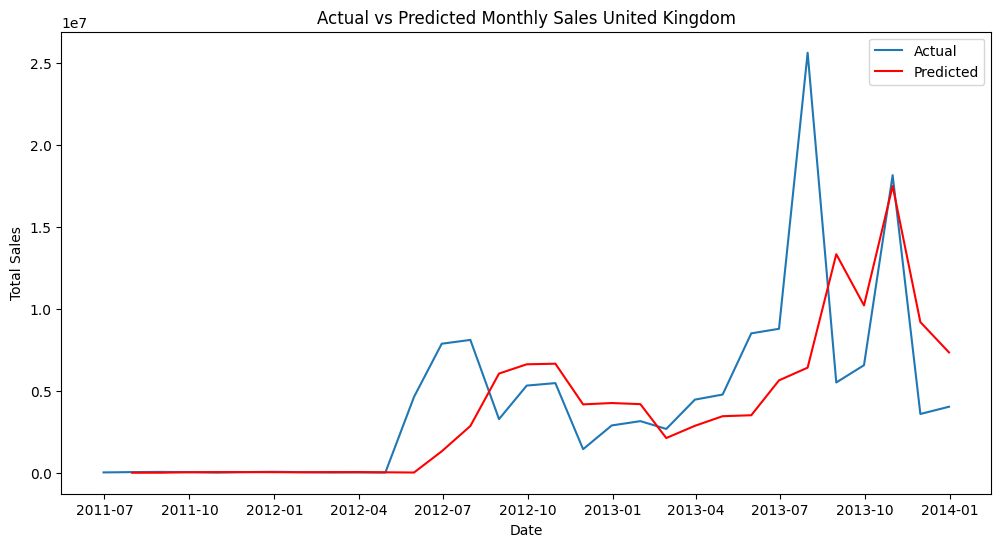

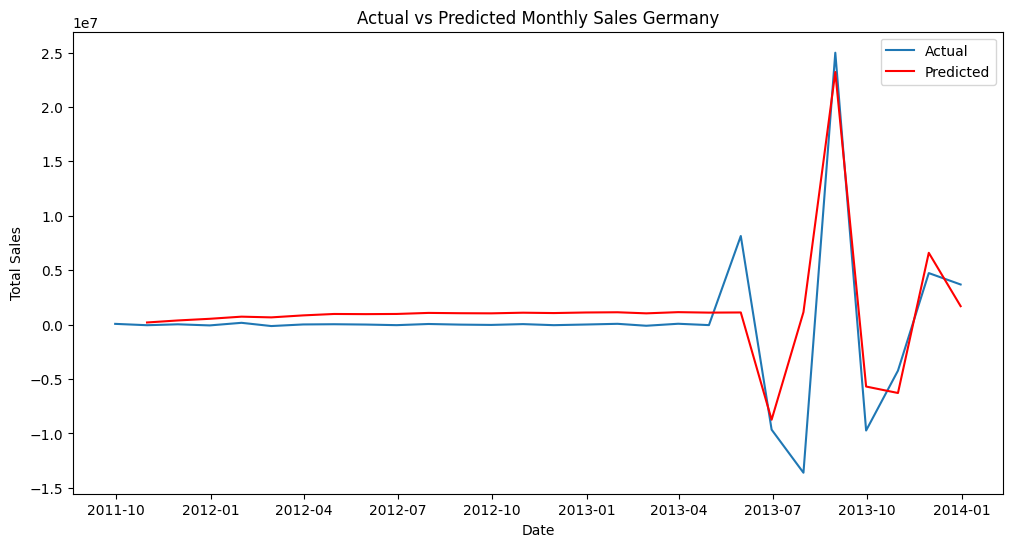

In [315]:
for (country, model) in model_fit_countries.items():
    # In-sample prediction
    predictions = model.predict(start=train_data[country].index[1], end=train_data[country].index[-1], typ='levels')

    # Plot actual vs predicted
    plt.figure(figsize=(12, 6))
    plt.plot(train_data[country], label='Actual')
    plt.plot(predictions, color='red', label='Predicted')
    plt.title('Actual vs Predicted Monthly Sales ' + country)
    plt.xlabel('Date')
    plt.ylabel('Total Sales')
    plt.legend()
    plt.show()


C:\Users\Hi There\AppData\Local\Temp\ipykernel_40644\3192731802.py:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=forecast_steps, freq='M')


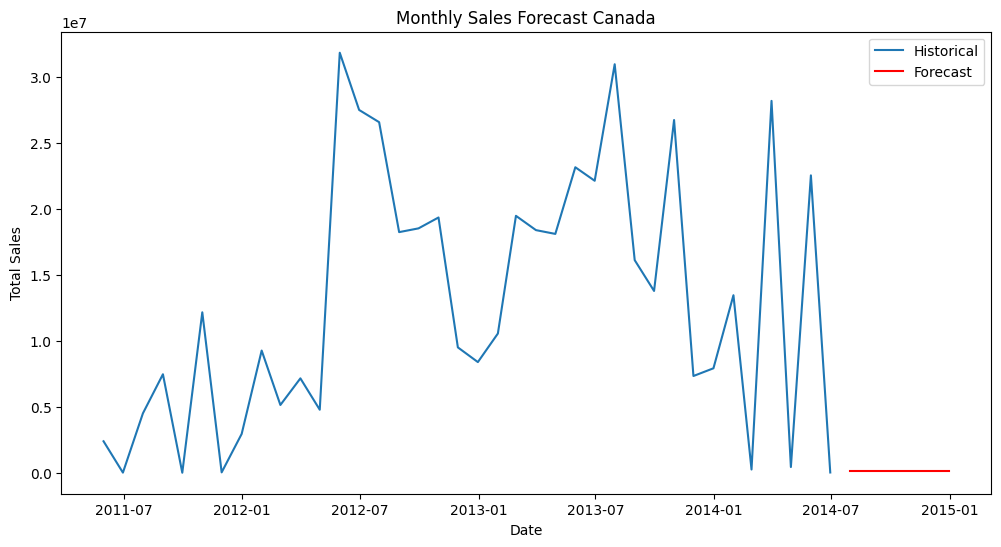

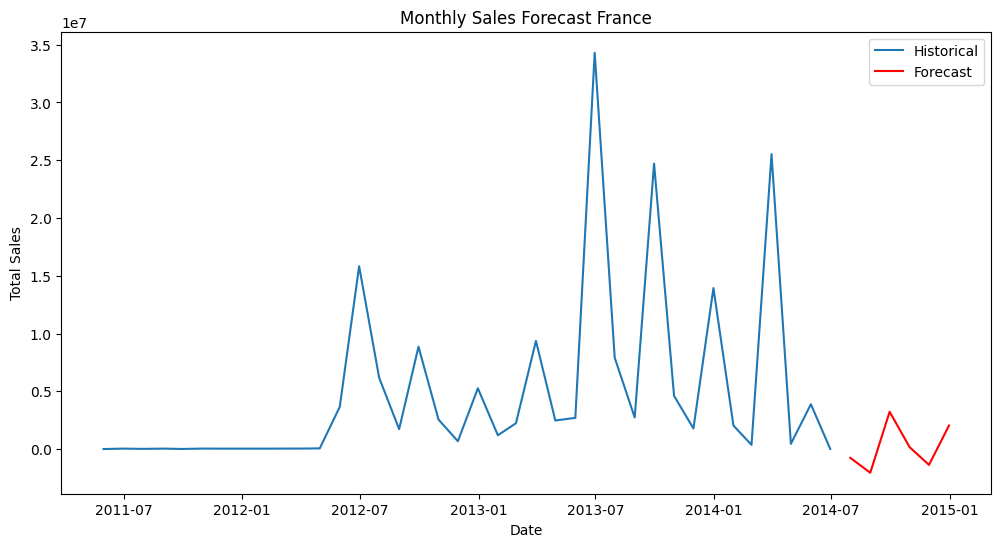

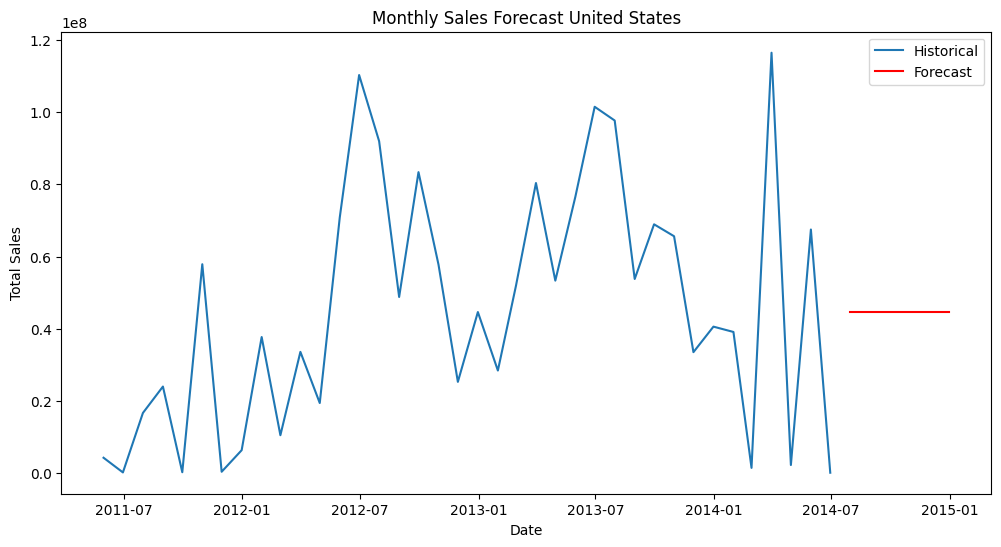

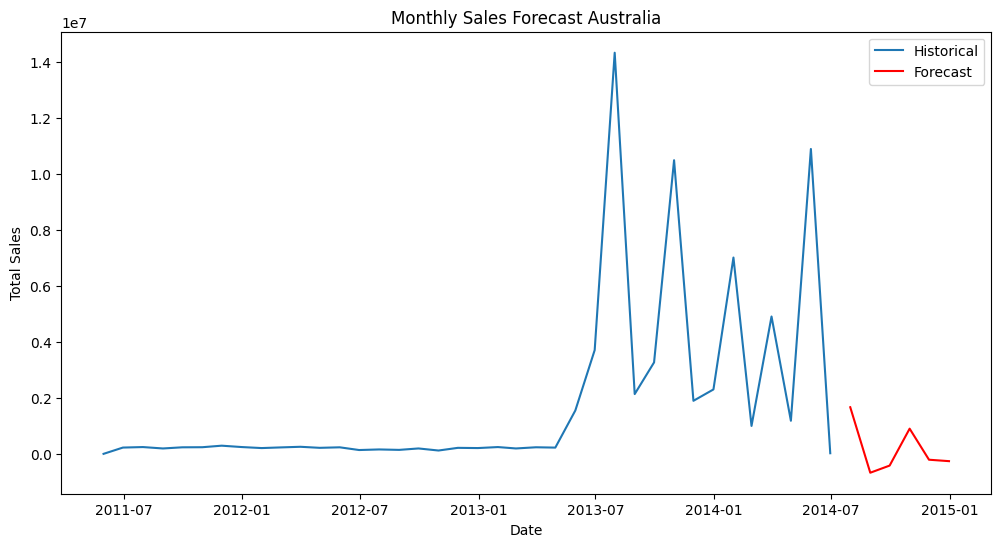

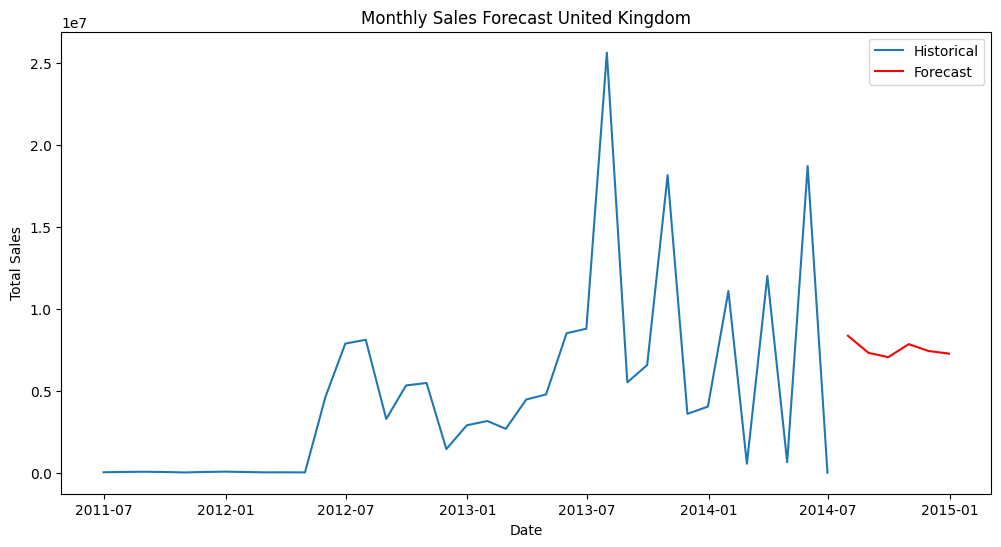

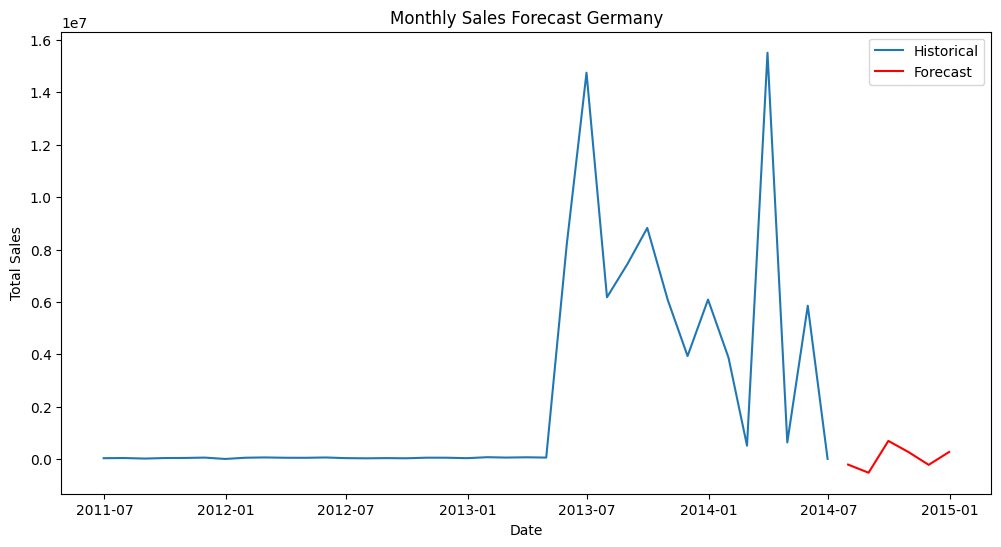

In [321]:
for (country, model) in model_fit_countries.items():
    # Forecasting
    forecast_steps = 12
    forecast = model.forecast(steps=forecast_steps)

    # Create future dates
    last_date = train_data[country].index[-1]
    forecast_index = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=forecast_steps, freq='M')

    # Create forecast series
    forecast_series = pd.Series(forecast, index=forecast_index)[-6:]

    # Plot the forecast
    plt.figure(figsize=(12, 6))
    plt.plot(combined_data[country], label='Historical')
    plt.plot(forecast_series, label='Forecast', color='red')
    plt.title('Monthly Sales Forecast ' + country)
    plt.xlabel('Date')
    plt.ylabel('Total Sales')
    plt.legend()
    plt.show()

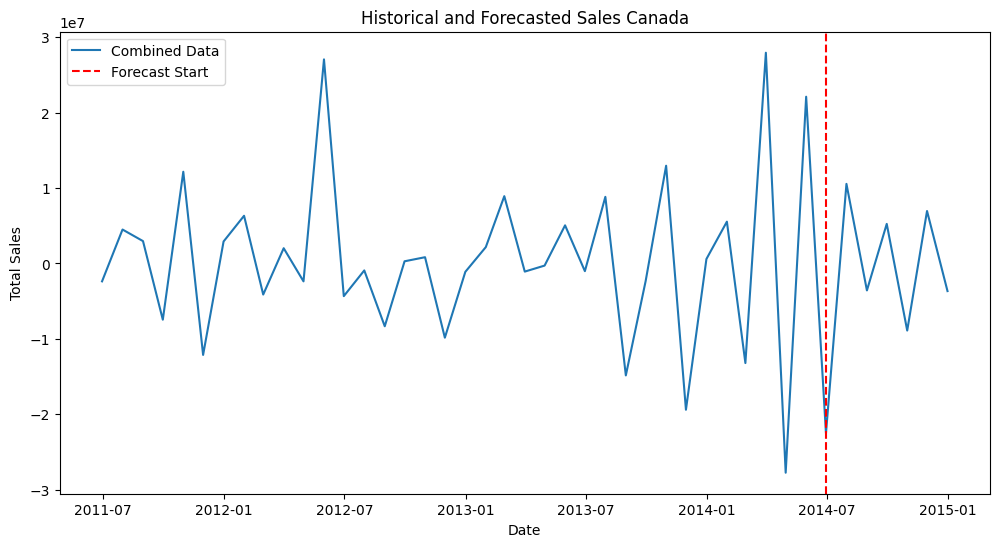

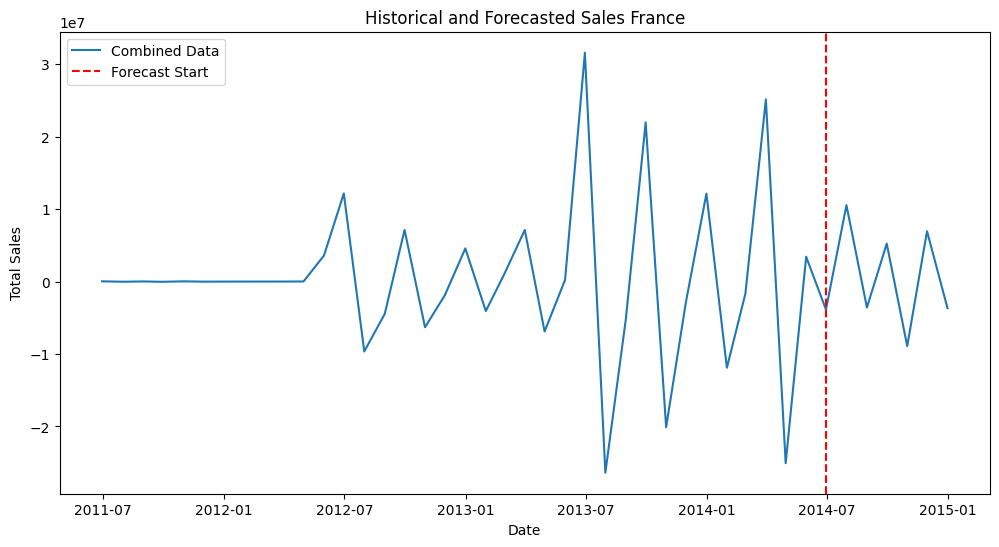

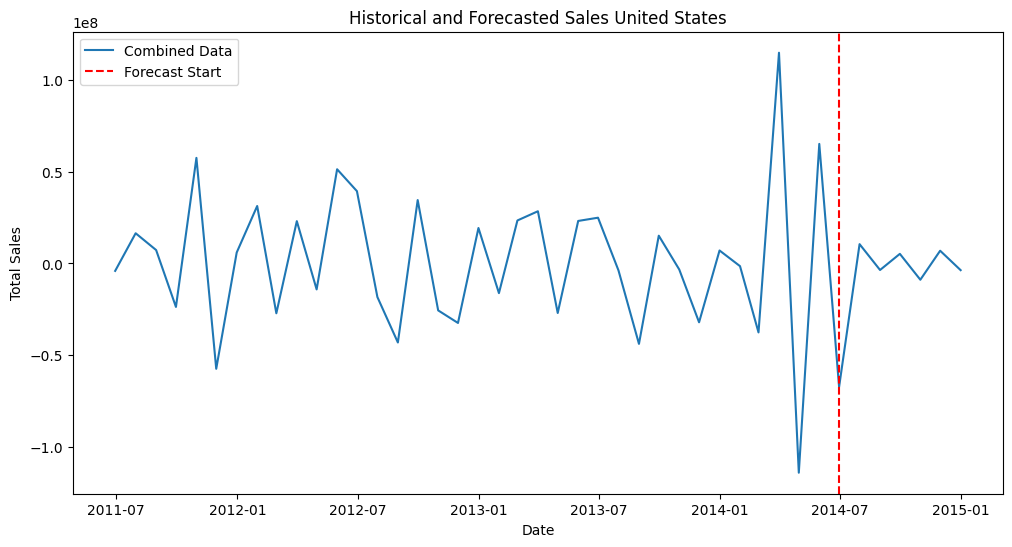

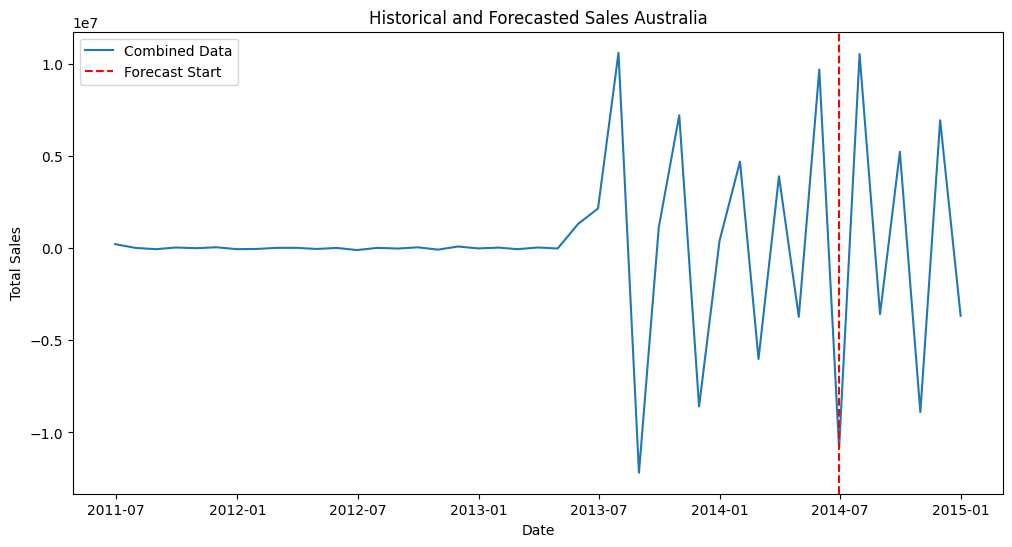

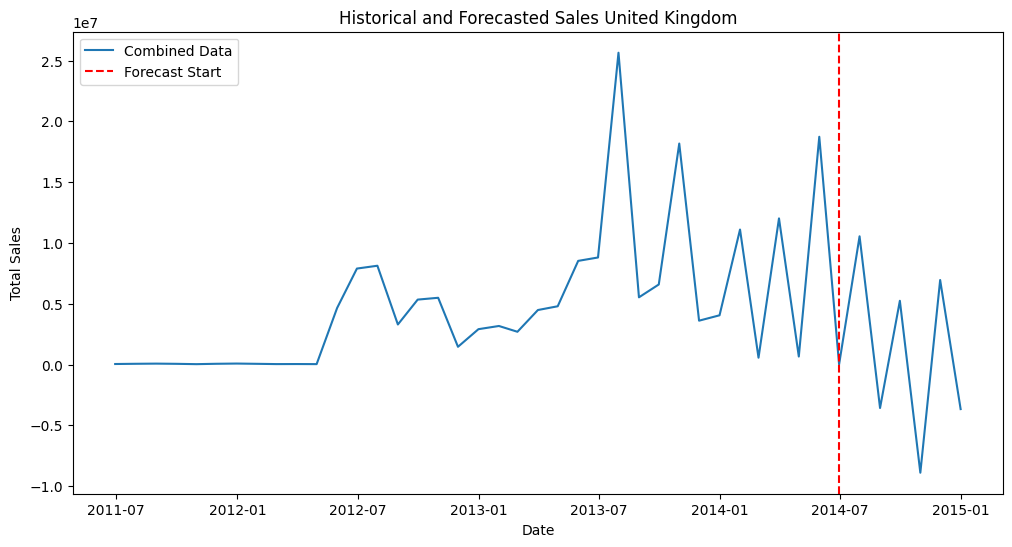

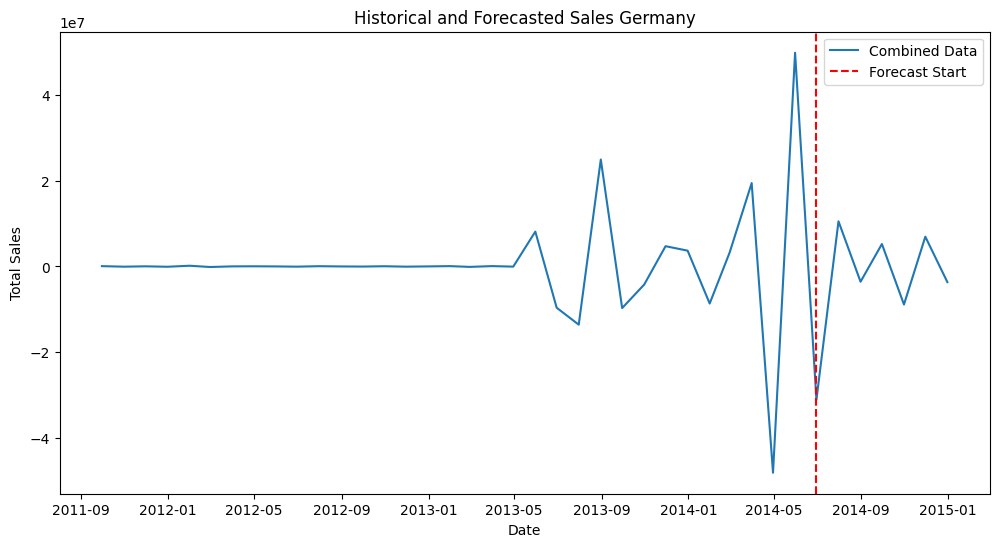

In [37]:
for (country, model) in model_fit_countries.items():
    # Combine historical and forecast data
    combined = pd.concat([monthly_sales_by_country[country], forecast_series], axis=0)

    # Plot combined data
    plt.figure(figsize=(12, 6))
    plt.plot(combined, label='Combined Data')
    plt.axvline(x=monthly_sales.index[-1], color='red', linestyle='--', label='Forecast Start')
    plt.title('Historical and Forecasted Sales ' + country)
    plt.xlabel('Date')
    plt.ylabel('Total Sales')
    plt.legend()
    plt.show()


## SARIMA (no significant seasonality was detected in the data.)

In [163]:
from pmdarima import auto_arima

for country, series in train_data.items():
    print(f"Finding best ARIMA order for {country}...")
    model = auto_arima(series, seasonal=True, trace=True, stepwise=True)
    print(f"Best ARIMA order for {country}: {model.order}")

Finding best ARIMA order for Canada...
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=1082.750, Time=0.29 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1082.549, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1079.950, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1079.044, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1080.562, Time=0.00 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1079.893, Time=0.03 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=1081.215, Time=0.02 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=1081.339, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1077.170, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1079.051, Time=0.07 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=1079.343, Time=0.12 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=1077.983, Time=0.01 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=1079.489, Time=0.39 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0]          
Total fit tim

## Machine Learning

In [164]:
# Resample 'TotalDue' for each country in the dictionary
combined_data, train_data, test_data = train_test_split_country(sales_data_country)

In [180]:
combined_data.keys()

dict_keys(['Canada', 'France', 'United States', 'Australia', 'United Kingdom', 'Germany'])

In [203]:
def add_lag(data, lags=3):
    lagged_data = {}  # To store the lagged DataFrames

    for country, series in data.items():
        print(f"Processing country: {country}")
        
        # Convert Series to DataFrame
        df = series.to_frame(name='sales')  # 'sales' becomes the column name
        
        # Add lag features
        for lag in range(1, lags + 1):
            df[f'sales_lag_{lag}'] = df['sales'].shift(lag)
        
        # Drop NaN rows caused by lagging
        df = df.dropna()

        # Save the processed DataFrame
        lagged_data[country] = df
        
        # Display first rows for validation
        print(type(lagged_data[country]))
        
    
    return lagged_data

In [204]:
lagged_combined_data = add_lag(combined_data, 3)

Processing country: Canada
<class 'pandas.core.frame.DataFrame'>
Processing country: France
<class 'pandas.core.frame.DataFrame'>
Processing country: United States
<class 'pandas.core.frame.DataFrame'>
Processing country: Australia
<class 'pandas.core.frame.DataFrame'>
Processing country: United Kingdom
<class 'pandas.core.frame.DataFrame'>
Processing country: Germany
<class 'pandas.core.frame.DataFrame'>


In [208]:
def split_data(lagged_combined_data):
    lagged_train_data = {}
    lagged_test_data = {}
    
    for country, data in lagged_combined_data.items():
        lagged_train_data[country], lagged_test_data[country] = data[:-6], data[-6:]
        print(type(data))
        
    return lagged_train_data, lagged_test_data

In [209]:
lagged_train_data, lagged_test_data = split_data(lagged_combined_data)

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


In [196]:
lagged_train_data

{'Canada':                    sales   sales_lag_1   sales_lag_2   sales_lag_3
 datetime                                                          
 2011-08-31  7.471918e+06  4.512899e+06  2.031782e+04  2.395443e+06
 2011-09-30  1.318235e+04  7.471918e+06  4.512899e+06  2.031782e+04
 2011-10-31  1.216474e+07  1.318235e+04  7.471918e+06  4.512899e+06
 2011-11-30  4.008776e+04  1.216474e+07  1.318235e+04  7.471918e+06
 2011-12-31  2.951436e+06  4.008776e+04  1.216474e+07  1.318235e+04
 2012-01-31  9.267895e+06  2.951436e+06  4.008776e+04  1.216474e+07
 2012-02-29  5.144809e+06  9.267895e+06  2.951436e+06  4.008776e+04
 2012-03-31  7.162063e+06  5.144809e+06  9.267895e+06  2.951436e+06
 2012-04-30  4.784907e+06  7.162063e+06  5.144809e+06  9.267895e+06
 2012-05-31  3.182959e+07  4.784907e+06  7.162063e+06  5.144809e+06
 2012-06-30  2.749437e+07  3.182959e+07  4.784907e+06  7.162063e+06
 2012-07-31  2.656807e+07  2.749437e+07  3.182959e+07  4.784907e+06
 2012-08-31  1.823936e+07  2.656807e+0

In [200]:
print(lagged_test_data.values())

dict_values([                   sales   sales_lag_1   sales_lag_2   sales_lag_3
datetime                                                          
2014-01-31  1.346066e+07  7.924098e+06  7.339794e+06  2.673192e+07
2014-02-28  2.559653e+05  1.346066e+07  7.924098e+06  7.339794e+06
2014-03-31  2.818234e+07  2.559653e+05  1.346066e+07  7.924098e+06
2014-04-30  4.437361e+05  2.818234e+07  2.559653e+05  1.346066e+07
2014-05-31  2.253944e+07  4.437361e+05  2.818234e+07  2.559653e+05
2014-06-30  3.117614e+04  2.253944e+07  4.437361e+05  2.818234e+07,                    sales   sales_lag_1   sales_lag_2   sales_lag_3
datetime                                                          
2014-01-31  2.037807e+06  1.393636e+07  1.782839e+06  4.605093e+06
2014-02-28  3.638423e+05  2.037807e+06  1.393636e+07  1.782839e+06
2014-03-31  2.552732e+07  3.638423e+05  2.037807e+06  1.393636e+07
2014-04-30  4.535782e+05  2.552732e+07  3.638423e+05  2.037807e+06
2014-05-31  3.881348e+06  4.535782e+05  2.552732

In [266]:
def train_simple_model(data):
    trained_models = {}
    scalers_X = {}

    for country, df in data.items():
        print(f"Training model for {country}...")

        # Features and target
        X = df[['sales_lag_1', 'sales_lag_2', 'sales_lag_3']]
        y = df['sales']

        # Scale features only
        scaler_X = StandardScaler()
        X_scaled = scaler_X.fit_transform(X)

        # Initialize a single model (Linear Regression for simplicity)
        model = LinearRegression()

        # Leave-One-Out Cross-Validation (LOOCV)
        loo = LeaveOneOut()
        y_preds = []
        y_actuals = []

        for train_index, test_index in loo.split(X_scaled):
            X_train, X_test = X_scaled[train_index], X_scaled[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

            # Train and predict
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

            y_preds.append(y_pred[0])
            y_actuals.append(y_test)

        # Compute LOOCV RMSE
        rmse = np.sqrt(mean_squared_error(y_actuals, y_preds))
        print(f"{country} - LOOCV RMSE: {rmse:.2f}")

        # Train on full data
        model.fit(X_scaled, y)

        # Save model and scaler
        trained_models[country] = model
        scalers_X[country] = scaler_X

    return trained_models, scalers_X

In [268]:
train_models, scalers_X = train_simple_model(lagged_train_data)

Training model for Canada...
Canada - LOOCV RMSE: 8777700.68
Training model for France...
France - LOOCV RMSE: 6396755.67
Training model for United States...
United States - LOOCV RMSE: 28793480.54
Training model for Australia...
Australia - LOOCV RMSE: 20032866.37
Training model for United Kingdom...
United Kingdom - LOOCV RMSE: 5829744.88
Training model for Germany...
Germany - LOOCV RMSE: 4479705.46


In [269]:
train_models

{'Canada': LinearRegression(),
 'France': LinearRegression(),
 'United States': LinearRegression(),
 'Australia': LinearRegression(),
 'United Kingdom': LinearRegression(),
 'Germany': LinearRegression()}

In [280]:
def test_simple_model(trained_models, scalers_X, test_data):
    countries_predict = {}
    
    for country, df in test_data.items():
        print(f"Testing model for {country}...")

        # Features and target
        X = df[['sales_lag_1', 'sales_lag_2', 'sales_lag_3']]
        y = df['sales']

        # Scale features using the saved scaler
        X_scaled = scalers_X[country].transform(X)

        # Predict
        y_pred = trained_models[country].predict(X_scaled)
        y_pred = pd.Series(y_pred, index=df.index)

        # Calculate MSE and RMSE
        mse = mean_squared_error(y, y_pred)
        rmse = np.sqrt(mse)

        # Print evaluation metrics
        print(f"{country} - Mean Squared Error (MSE): {mse:.2f}")
        print(f"{country} - Root Mean Squared Error (RMSE): {rmse:.2f}\n")
        
        countries_predict[country] = y_pred
        
    return countries_predict

In [281]:
countries_predict = test_simple_model(train_models, scalers_X, lagged_test_data)

Testing model for Canada...
Canada - Mean Squared Error (MSE): 217841436003728.88
Canada - Root Mean Squared Error (RMSE): 14759452.43

Testing model for France...
France - Mean Squared Error (MSE): 108057916941796.39
France - Root Mean Squared Error (RMSE): 10395091.00

Testing model for United States...
United States - Mean Squared Error (MSE): 3494742900452484.00
United States - Root Mean Squared Error (RMSE): 59116350.53

Testing model for Australia...
Australia - Mean Squared Error (MSE): 25668157977080.72
Australia - Root Mean Squared Error (RMSE): 5066375.23

Testing model for United Kingdom...
United Kingdom - Mean Squared Error (MSE): 90260531211838.52
United Kingdom - Root Mean Squared Error (RMSE): 9500554.26

Testing model for Germany...
Germany - Mean Squared Error (MSE): 103391414339776.95
Germany - Root Mean Squared Error (RMSE): 10168156.88



In [283]:
countries_predict

{'Canada': datetime
 2014-01-31    1.236482e+07
 2014-02-28    1.281681e+07
 2014-03-31    8.540125e+06
 2014-04-30    1.799643e+07
 2014-05-31    9.893975e+06
 2014-06-30    1.718494e+07
 Freq: ME, dtype: float64,
 'France': datetime
 2014-01-31    6.409023e+06
 2014-02-28    2.243318e+06
 2014-03-31    1.135721e+07
 2014-04-30    5.883979e+06
 2014-05-31   -1.785656e+04
 2014-06-30    1.951008e+07
 Freq: ME, dtype: float64,
 'United States': datetime
 2014-01-31    5.058686e+07
 2014-02-28    4.354319e+07
 2014-03-31    3.055928e+07
 2014-04-30    7.279114e+07
 2014-05-31    2.567855e+07
 2014-06-30    7.035151e+07
 Freq: ME, dtype: float64,
 'Australia': datetime
 2014-01-31    7.422239e+06
 2014-02-28    3.072538e+06
 2014-03-31    2.175053e+06
 2014-04-30    5.798993e+06
 2014-05-31    1.431244e+06
 2014-06-30    5.627185e+06
 Freq: ME, dtype: float64,
 'United Kingdom': datetime
 2014-01-31    1.195238e+07
 2014-02-28    5.711484e+06
 2014-03-31    4.478958e+06
 2014-04-30    9.5

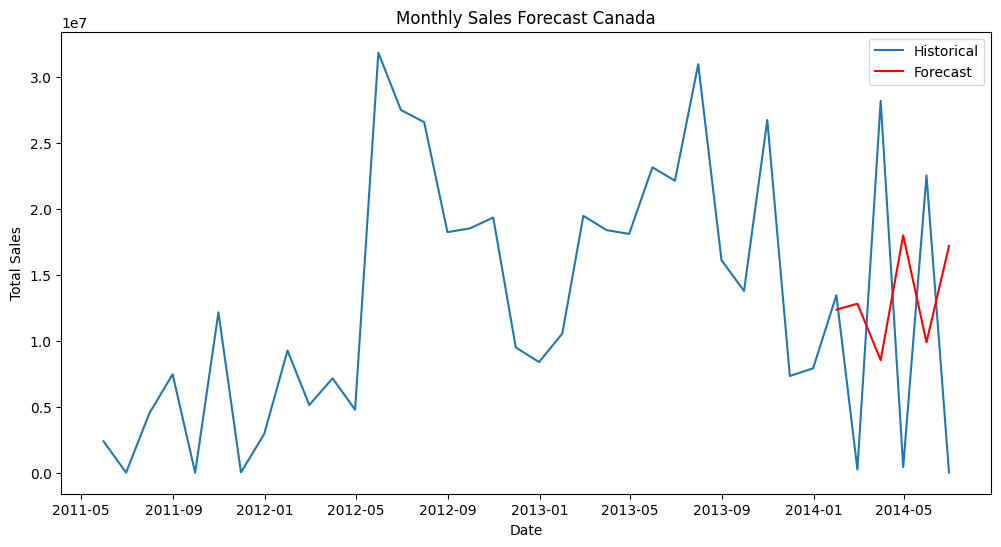

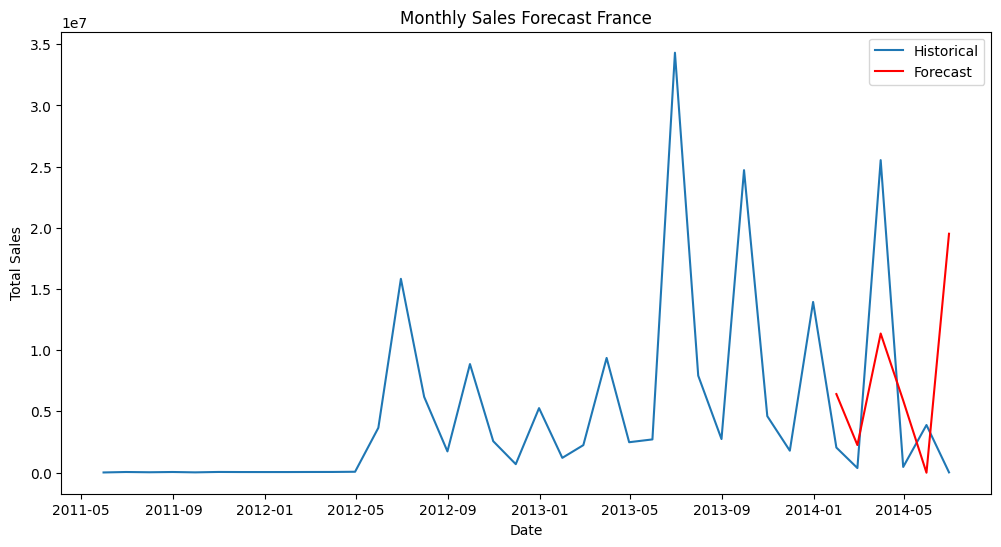

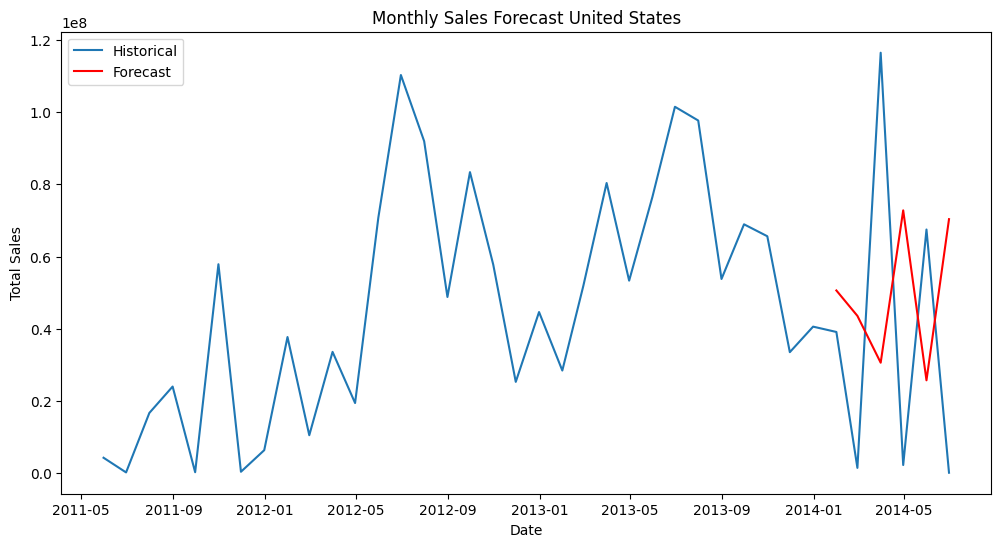

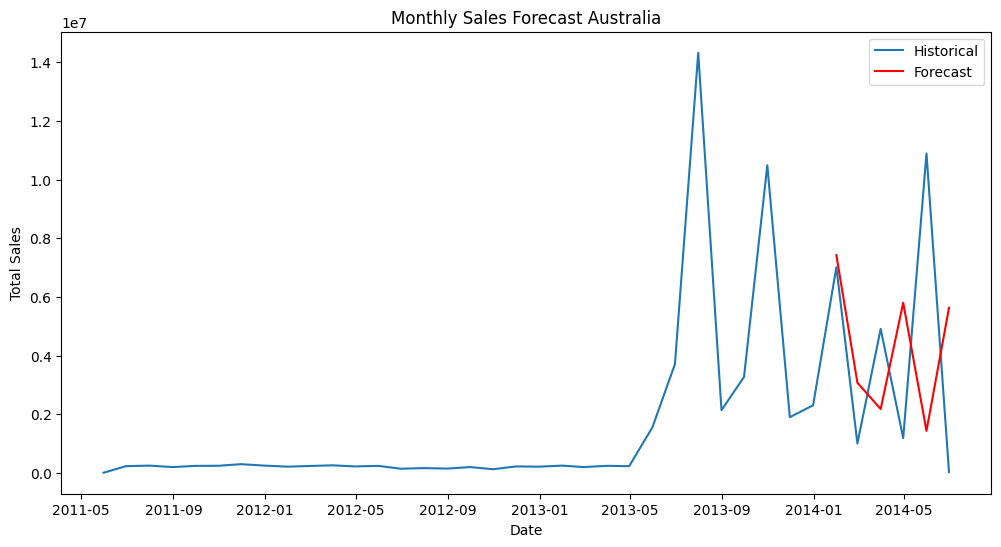

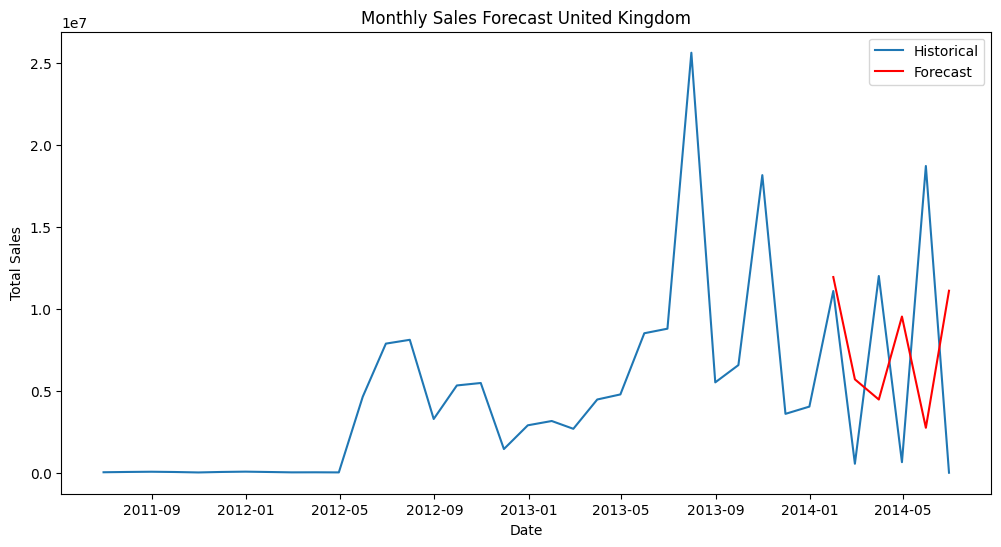

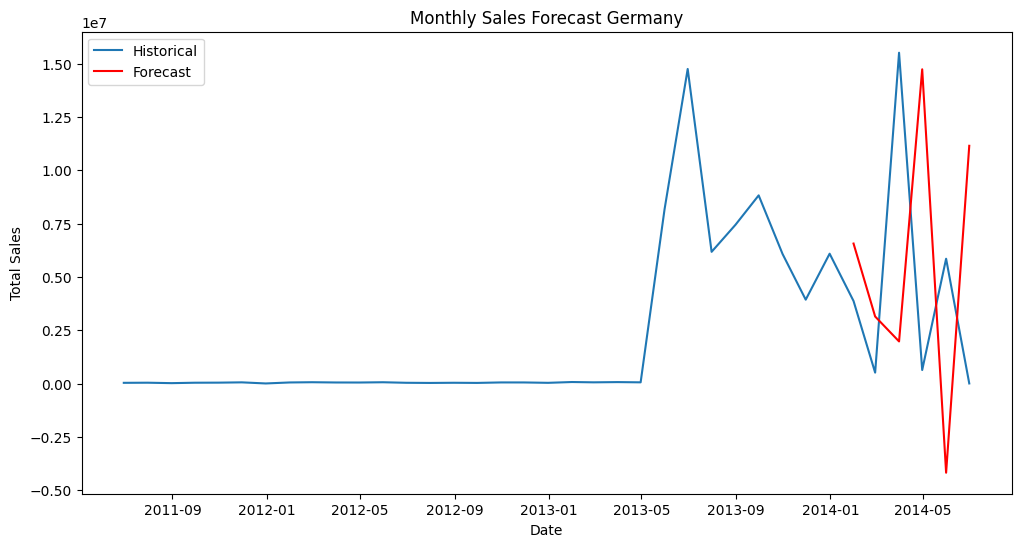

In [284]:
for (country, model) in model_fit_countries.items():

    # Plot the forecast
    plt.figure(figsize=(12, 6))
    plt.plot(combined_data[country], label='Historical')
    plt.plot(countries_predict[country], label='Forecast', color='red')
    plt.title('Monthly Sales Forecast ' + country)
    plt.xlabel('Date')
    plt.ylabel('Total Sales')
    plt.legend()
    plt.show()

In [287]:
def forecast_next_months(trained_models, scalers_X, data, months=6):
    future_forecasts = {}

    for country, model in trained_models.items():
        print(f"Forecasting for {country}...")

        # Get the last row of the dataset for lagged features
        last_row = data[country].iloc[-1]
        lag_1, lag_2, lag_3 = last_row['sales_lag_1'], last_row['sales_lag_2'], last_row['sales_lag_3']

        # Start forecasting from the last date in the dataset
        last_date = data[country].index[-1]

        # Generate future dates
        future_dates = pd.date_range(start=last_date, periods=months + 1, freq='M')[1:]

        # List to store forecasts
        forecasts = []

        for date in future_dates:
            # Create features for the current prediction
            X_new = pd.DataFrame([[lag_1, lag_2, lag_3]], columns=['sales_lag_1', 'sales_lag_2', 'sales_lag_3'])

            # Scale features
            scaler_X = scalers_X[country]
            X_new_scaled = scaler_X.transform(X_new)

            # Predict the next month's sales
            next_sales = model.predict(X_new_scaled)[0]

            # Append prediction to the forecasts
            forecasts.append(next_sales)

            # Update lagged features
            lag_3 = lag_2
            lag_2 = lag_1
            lag_1 = next_sales

        # Convert forecasts to pandas Series with dates as the index
        future_forecasts[country] = pd.Series(data=forecasts, index=future_dates, name='forecast')

    return future_forecasts


In [289]:
future_forecasts = forecast_next_months(train_models, scalers_X, lagged_test_data, 6)
future_forecasts

Forecasting for Canada...
Forecasting for France...
Forecasting for United States...
Forecasting for Australia...
Forecasting for United Kingdom...
Forecasting for Germany...


C:\Users\Hi There\AppData\Local\Temp\ipykernel_40644\681475447.py:15: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=last_date, periods=months + 1, freq='M')[1:]
C:\Users\Hi There\AppData\Local\Temp\ipykernel_40644\681475447.py:15: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=last_date, periods=months + 1, freq='M')[1:]
C:\Users\Hi There\AppData\Local\Temp\ipykernel_40644\681475447.py:15: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=last_date, periods=months + 1, freq='M')[1:]
C:\Users\Hi There\AppData\Local\Temp\ipykernel_40644\681475447.py:15: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=last_date, periods=months + 1, freq='M')[

{'Canada': 2014-07-31    1.718494e+07
 2014-08-31    1.558466e+07
 2014-09-30    1.624917e+07
 2014-10-31    1.580568e+07
 2014-11-30    1.557979e+07
 2014-12-31    1.549361e+07
 Freq: ME, Name: forecast, dtype: float64,
 'France': 2014-07-31    1.951008e+07
 2014-08-31    3.940990e+06
 2014-09-30    3.235315e+06
 2014-10-31    1.511130e+07
 2014-11-30    5.925716e+06
 2014-12-31    3.431800e+06
 Freq: ME, Name: forecast, dtype: float64,
 'United States': 2014-07-31    7.035151e+07
 2014-08-31    4.998692e+07
 2014-09-30    5.603855e+07
 2014-10-31    5.815383e+07
 2014-11-30    5.491975e+07
 2014-12-31    5.503835e+07
 Freq: ME, Name: forecast, dtype: float64,
 'Australia': 2014-07-31    5.627185e+06
 2014-08-31    2.328562e+06
 2014-09-30    7.647026e+06
 2014-10-31    5.456960e+06
 2014-11-30    3.012563e+06
 2014-12-31    5.805706e+06
 Freq: ME, Name: forecast, dtype: float64,
 'United Kingdom': 2014-07-31    1.111796e+07
 2014-08-31    4.789296e+06
 2014-09-30    1.265378e+07
 201

C:\Users\Hi There\AppData\Local\Temp\ipykernel_40644\1407805102.py:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=forecast_steps, freq='M')


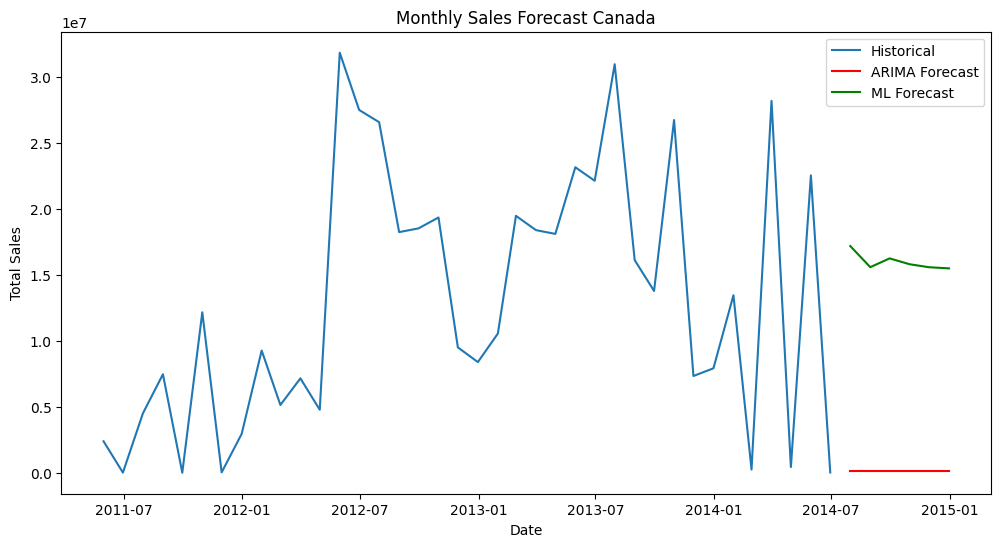

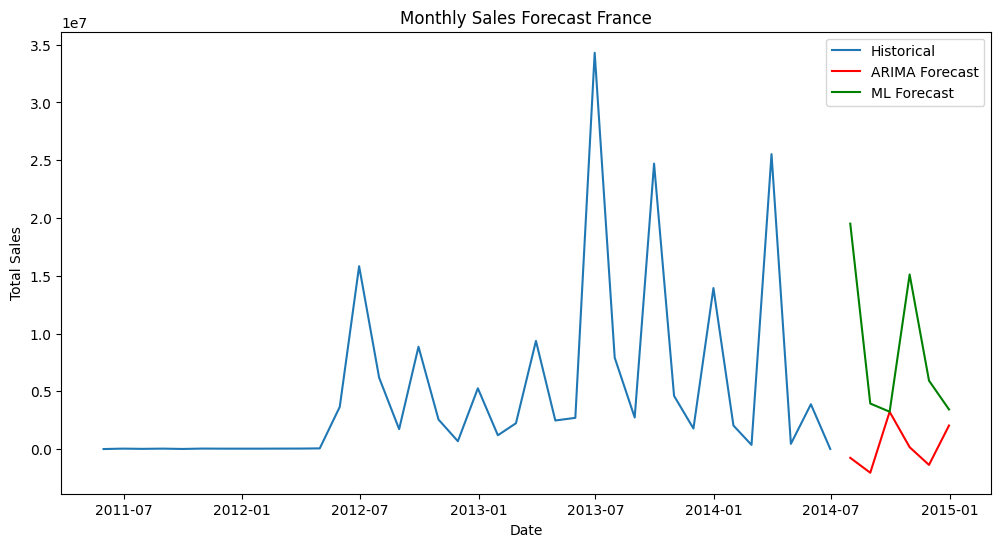

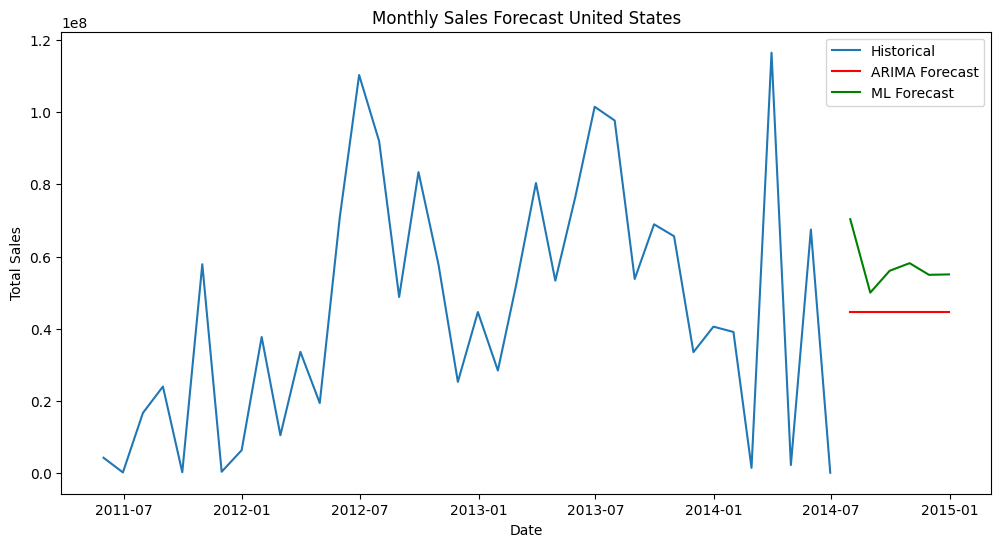

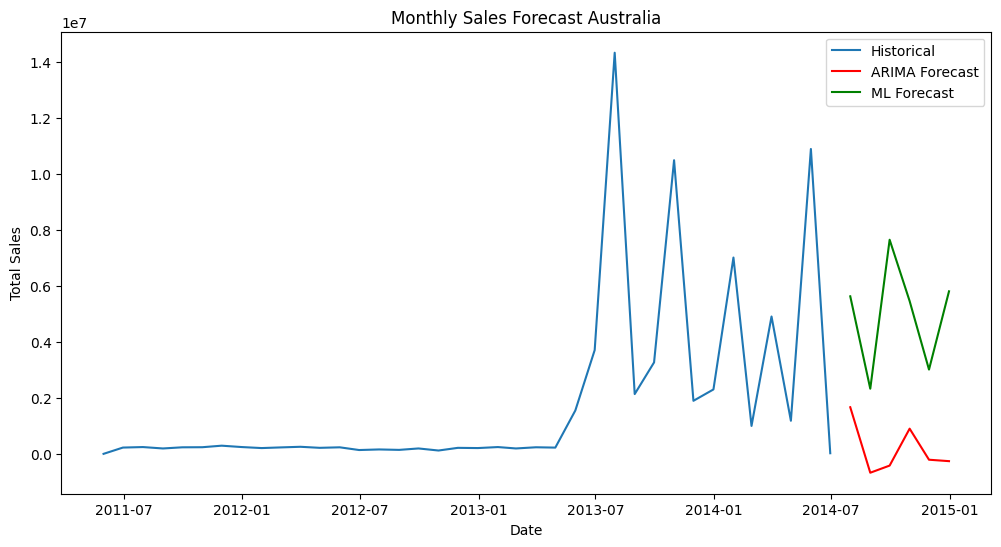

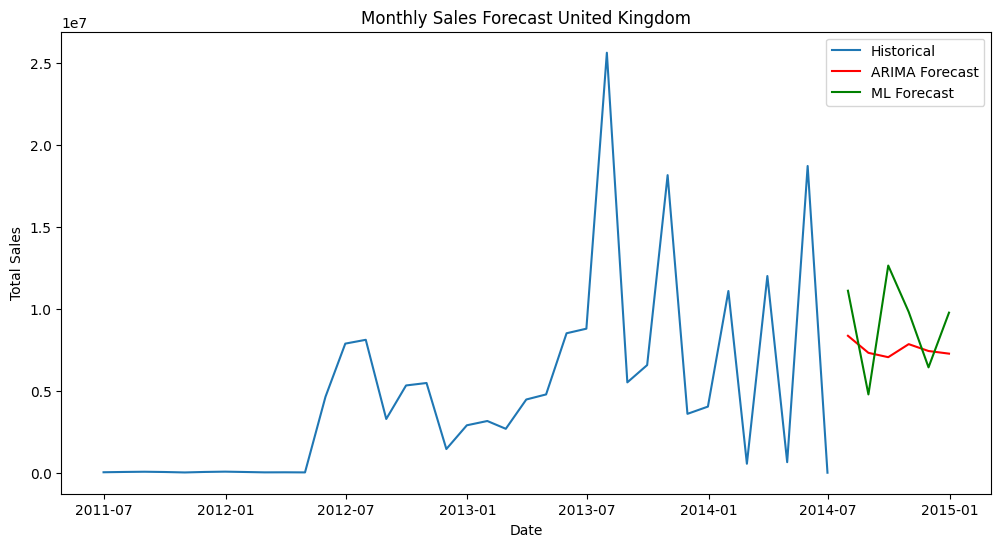

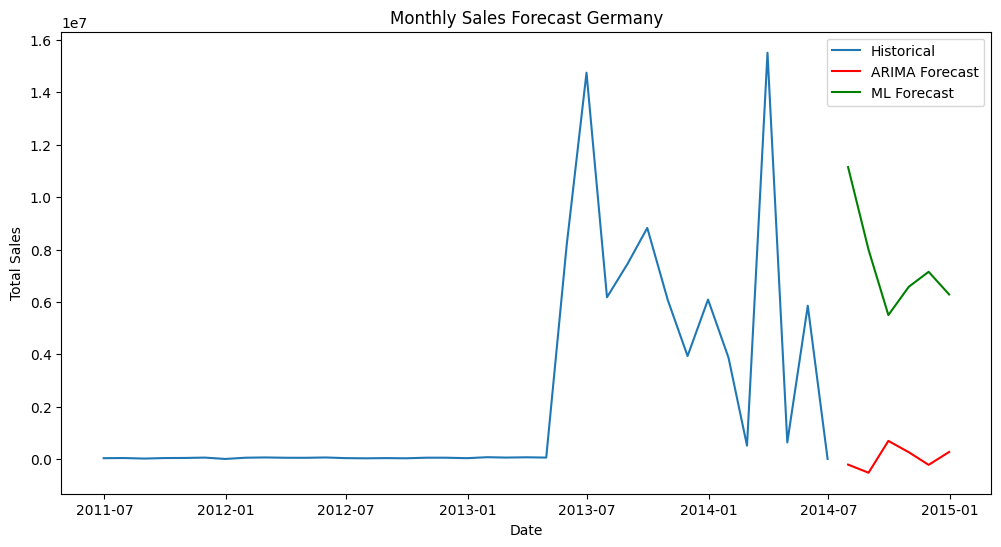

In [323]:
for (country, model) in model_fit_countries.items():
    # Forecasting
    forecast_steps = 12
    forecast = model.forecast(steps=forecast_steps)

    # Create future dates
    last_date = train_data[country].index[-1]
    forecast_index = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=forecast_steps, freq='M')

    # Create forecast series
    forecast_series = pd.Series(forecast, index=forecast_index)[-6:]

    # Plot the forecast
    plt.figure(figsize=(12, 6))
    plt.plot(combined_data[country], label='Historical')
    plt.plot(forecast_series, label='ARIMA Forecast', color='red')
    plt.plot(future_forecasts[country], label='ML Forecast', color='green')
    plt.title('Monthly Sales Forecast ' + country)
    plt.xlabel('Date')
    plt.ylabel('Total Sales')
    plt.legend()
    plt.show()
